# Loading data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# all imports are preprocessed in my laptop because colab doesnt have enough disk space. I have provided the notebook I ran on laptop as well
from scipy import sparse

byte_matrix = sparse.load_npz('/content/gdrive/My Drive/Colab Notebooks/Malware uploads/normalized_byte.npz')

In [ ]:
import pickle

y_for_bytes = pickle.load(open('/content/gdrive/My Drive/Colab Notebooks/Malware uploads/y_values_for_bytes.pkl','rb'))

In [ ]:
y_for_bytes.head()

,Id,Class
0,01azqd4InC7m9JpocGv5,9
1,01IsoiSMh5gxyDYTl4CB,2
2,01jsnpXSAlgw6aPeDxrU,9
3,01kcPWA9K2BOxQeS5Rju,1
4,01SuzwMJEIXsK7A8dQbl,8


In [ ]:
byte_class = y_for_bytes['Class']

from sklearn.model_selection import train_test_split

bytes_train, bytes_test, train_labels, test_labels = train_test_split(byte_matrix, byte_class, test_size=0.33, stratify=byte_class)

In [ ]:
# from reference notebook
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(20,10))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(20,10))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(20,10))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

# Byte bigram modelling


## Getting important features

The total size of the byte_bigram is 10868x66049. Since there is not enough computational power available to me yet, I am using only top 200 features. So the total now is 10868x200

All the models are taken from reference notebook with little to no changes

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 200, n_jobs = -1)
rf.fit(bytes_train, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
import numpy as np

imp_idx = np.flip(np.argsort(rf.feature_importances_,)) # getting most important feature index first and so on

In [ ]:
from tqdm import tqdm

imp_bytes_train = np.zeros((bytes_train.shape[0], 0))
imp_bytes_test = np.zeros((bytes_test.shape[0], 0))

for i in tqdm(imp_idx[:200]):
  train = bytes_train[:, i].todense()
  imp_bytes_train =  np.hstack([imp_bytes_train, train])
  test = bytes_test[:, i].todense()
  imp_bytes_test =  np.hstack([imp_bytes_test, test])

100%|██████████| 200/200 [02:52<00:00,  1.16it/s]


In [ ]:
imp_bytes_train.shape, imp_bytes_test.shape

((7281, 200), (3587, 200))

## Random forest

log_loss for c =  10 is 0.09192520939397872
log_loss for c =  50 is 0.07687157616641149
log_loss for c =  100 is 0.07545500797502867
log_loss for c =  500 is 0.07330084114718499
log_loss for c =  1000 is 0.07318507660571771
log_loss for c =  2000 is 0.07319399798914586
log_loss for c =  3000 is 0.07322552041726488


<Figure size 1440x720 with 0 Axes>

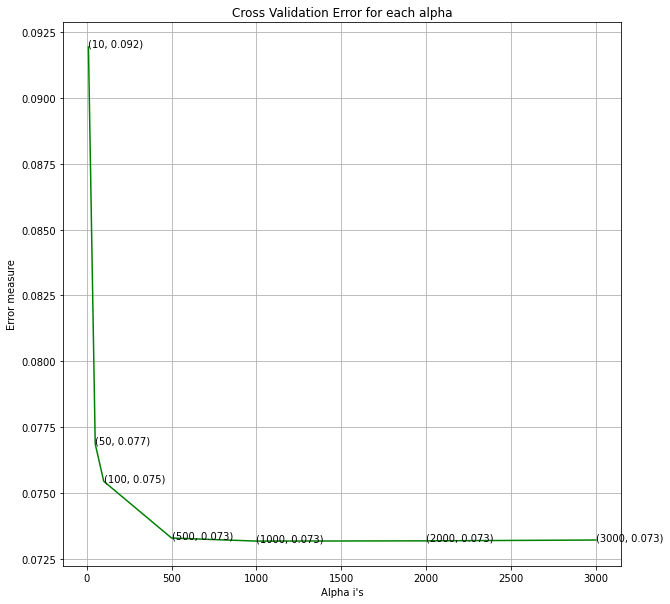

CPU times: user 20min 24s, sys: 30.5 s, total: 20min 54s
Wall time: 6min 18s


In [ ]:
%%time
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss

alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
train_log_error_array=[]

for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(imp_bytes_train,train_labels)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(imp_bytes_train, train_labels)
    predict_y = sig_clf.predict_proba(imp_bytes_test)
    cv_log_error_array.append(log_loss(test_labels, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
plt.figure(figsize=(10,10))
plt.plot(alpha, cv_log_error_array,c='g')

for i, txt in enumerate(np.round(cv_log_error_array,3)):
    plt.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))

plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [ ]:
%%time
plt.close()
r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(imp_bytes_train,train_labels)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(imp_bytes_train,train_labels)

predict_y = sig_clf.predict_proba(imp_bytes_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_labels, predict_y))
#predict_y = sig_clf.predict_proba(X_cv_merge)
#print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv_merge, predict_y))
predict_y = sig_clf.predict_proba(imp_bytes_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_labels, predict_y))

For values of best alpha =  1000 The train log loss is: 0.019401835472447667
For values of best alpha =  1000 The test log loss is: 0.07318507660571771
CPU times: user 3min 13s, sys: 5.47 s, total: 3min 19s
Wall time: 1min


Number of misclassified points  1.6448285475327573
-------------------------------------------------- Confusion matrix --------------------------------------------------


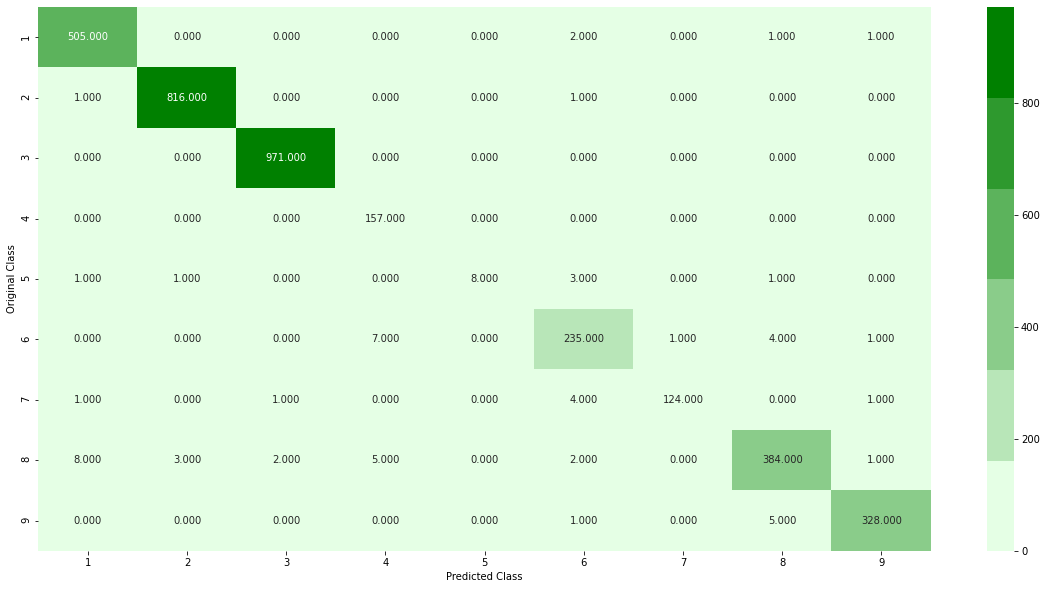

-------------------------------------------------- Precision matrix --------------------------------------------------


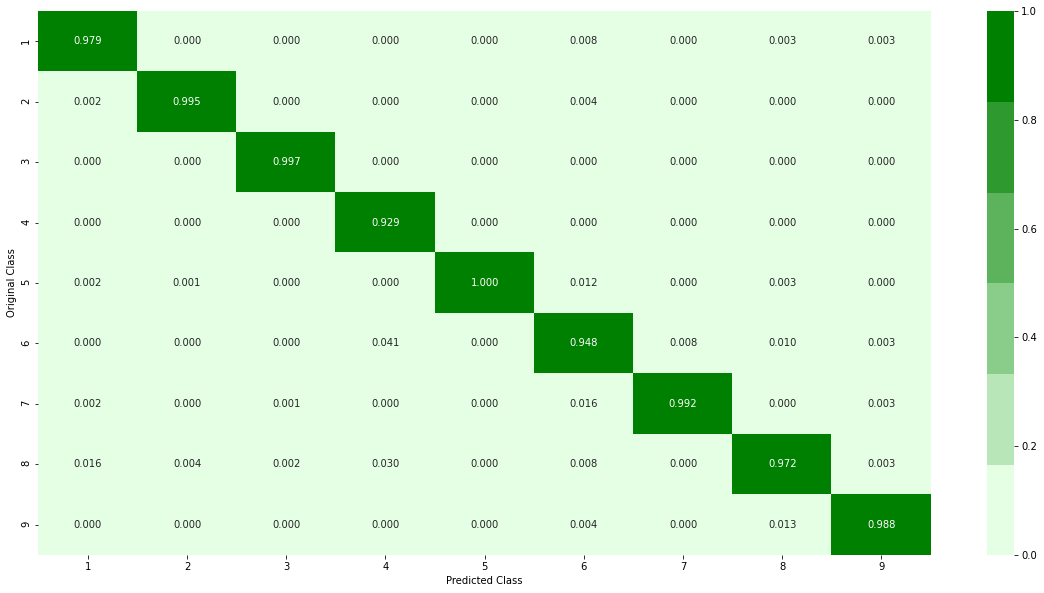

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


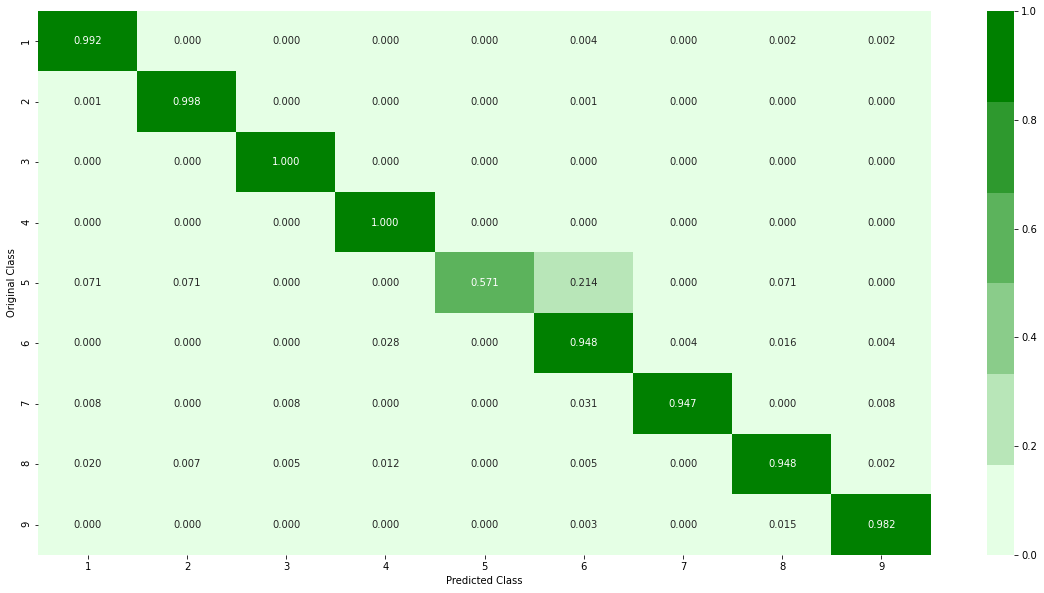

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.close()
plot_confusion_matrix(test_labels,sig_clf.predict(imp_bytes_test))

## XGB Classifier fully tuned

In [ ]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
# from reference notebook

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}

random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl.fit(imp_bytes_train, train_labels)

print(random_cfl.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 31.3min finished


{'subsample': 0.3, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.5}


In [ ]:
%%time
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------
x_cfl=XGBClassifier(n_estimators=200,max_depth=5,learning_rate=0.2,colsample_bytree=0.5,subsample=0.3,nthread=-1)
x_cfl.fit(imp_bytes_train,train_labels,verbose=True)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(imp_bytes_train, train_labels)

predict_y = sig_clf.predict_proba(imp_bytes_train)
print ('train loss',log_loss(train_labels, predict_y))
predict_y = sig_clf.predict_proba(imp_bytes_test)
print ('test loss',log_loss(test_labels, predict_y))

train loss 0.022174503803579444
test loss 0.07478620237157677
CPU times: user 2min 41s, sys: 196 ms, total: 2min 41s
Wall time: 2min 41s


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Number of misclassified points  1.533314747700028
-------------------------------------------------- Confusion matrix --------------------------------------------------


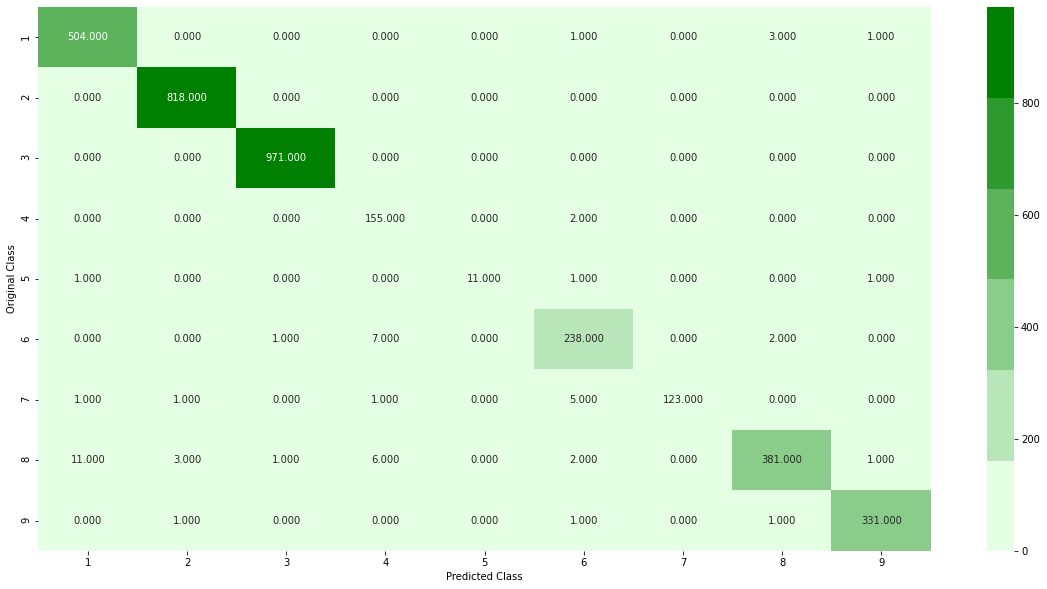

-------------------------------------------------- Precision matrix --------------------------------------------------


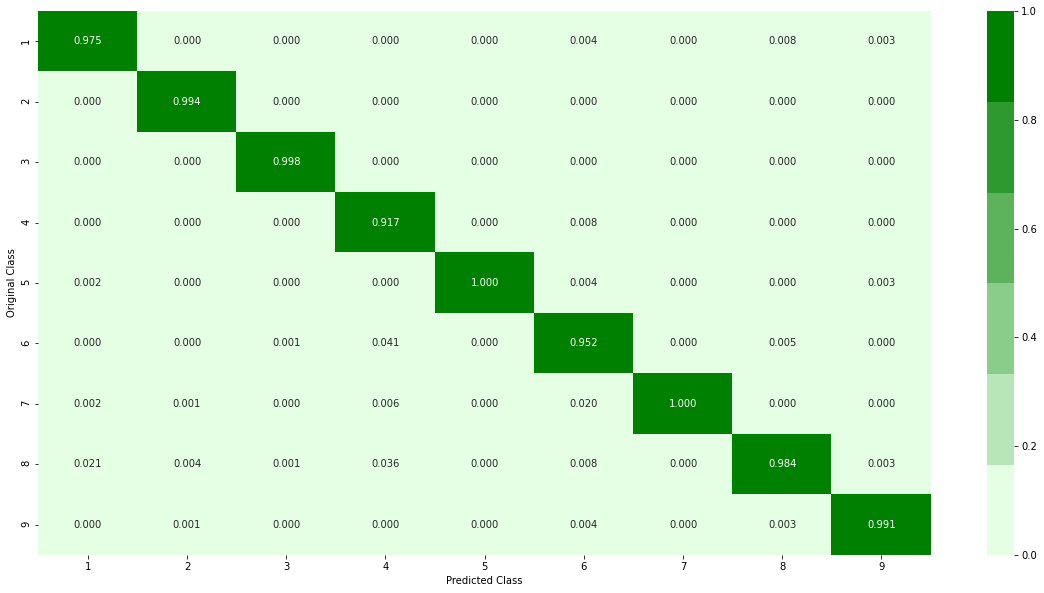

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


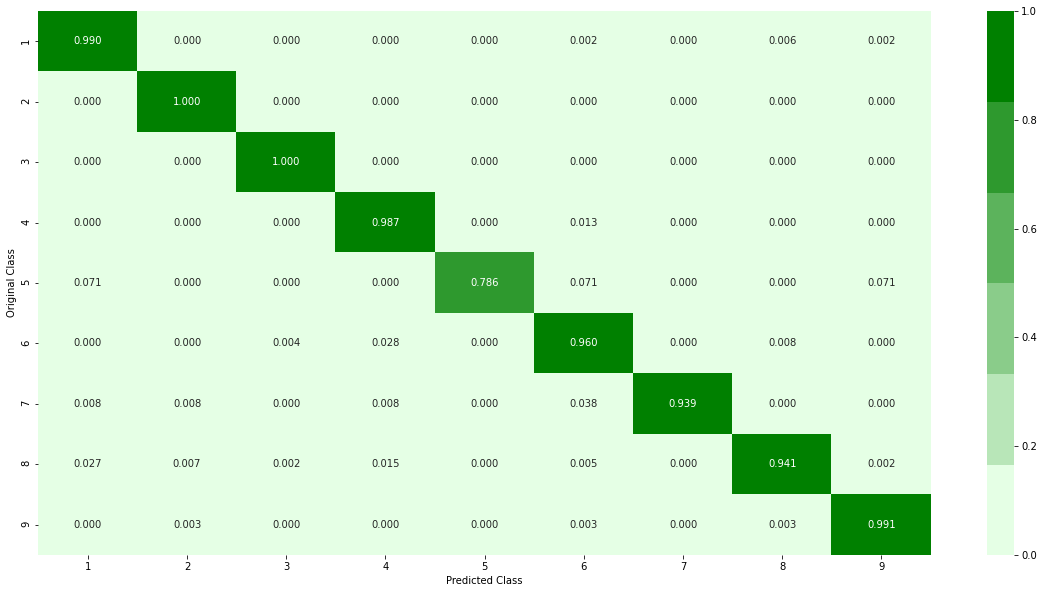

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.close()
plot_confusion_matrix(test_labels,sig_clf.predict(imp_bytes_test))

# ASM modelling

## Get data

In [ ]:
import pickle

pixel_array = pickle.load(open('/content/gdrive/My Drive/Colab Notebooks/Malware uploads/pixel_array.pkl', 'rb'))

In [ ]:
pixel_y = pixel_array['Class']
pixel_array = pixel_array.drop(['Class','Id'], axis=1)
pixel_array.head()

,pix1,pix2,pix3,pix4,pix5,pix6,pix7,pix8,pix9,pix10,pix11,pix12,pix13,pix14,pix15,pix16,pix17,pix18,pix19,pix20,pix21,pix22,pix23,pix24,pix25,pix26,pix27,pix28,pix29,pix30,pix31,pix32,pix33,pix34,pix35,pix36,pix37,pix38,pix39,pix40,...,pix761,pix762,pix763,pix764,pix765,pix766,pix767,pix768,pix769,pix770,pix771,pix772,pix773,pix774,pix775,pix776,pix777,pix778,pix779,pix780,pix781,pix782,pix783,pix784,pix785,pix786,pix787,pix788,pix789,pix790,pix791,pix792,pix793,pix794,pix795,pix796,pix797,pix798,pix799,pix800
0,0.010268,0.008033,0.008320,0.007913,0.008107,0.010204,0.009955,0.009506,0.009249,0.009789,0.009422,0.009592,0.009592,0.009592,0.010854,0.009582,0.009564,0.009549,0.009592,0.009592,0.005025,0.005025,0.010471,0.006530,0.005449,0.010567,0.010543,0.009751,0.010868,0.010890,0.010460,0.00738,0.007155,0.006451,0.007008,0.009020,0.009589,0.009592,0.009407,0.009593,...,0.001358,0.007929,0.004434,0.010599,0.009311,0.008227,0.008202,0.008916,0.008844,0.008555,0.008353,0.010589,0.009222,0.008229,0.008472,0.008577,0.007968,0.008147,0.008478,0.008505,0.009610,0.009617,0.011791,0.009728,0.009394,0.008258,0.010045,0.009446,0.009417,0.009470,0.007845,0.007574,0.008736,0.008160,0.007434,0.009323,0.007726,0.007915,0.008179,0.007428
1,0.006560,0.013504,0.012927,0.013963,0.013629,0.007218,0.008239,0.009506,0.010020,0.009036,0.009618,0.009592,0.009592,0.009592,0.002035,0.009582,0.009564,0.009549,0.009592,0.009592,0.017867,0.017867,0.005679,0.016075,0.017437,0.004696,0.004890,0.008850,0.002078,0.001578,0.005868,0.01476,0.015055,0.016127,0.015634,0.010899,0.009589,0.009592,0.010191,0.009593,...,0.004828,0.007795,0.004434,0.013901,0.016943,0.015375,0.015596,0.014177,0.014208,0.015146,0.013830,0.001562,0.015269,0.016188,0.014028,0.013920,0.015284,0.015493,0.013482,0.013665,0.017014,0.015923,0.006186,0.016267,0.017095,0.015432,0.005269,0.008672,0.007410,0.007918,0.007202,0.006705,0.004583,0.005351,0.009749,0.010545,0.005193,0.001687,0.001341,0.005602
2,0.010268,0.008033,0.008320,0.007913,0.008107,0.010204,0.009955,0.009506,0.009249,0.009789,0.009422,0.009592,0.009592,0.009592,0.010854,0.009582,0.009564,0.009549,0.009592,0.009592,0.005025,0.005025,0.010471,0.006530,0.005449,0.010567,0.010543,0.009751,0.010868,0.010890,0.010460,0.00738,0.007155,0.006451,0.007008,0.009020,0.009589,0.009592,0.009407,0.009593,...,0.001358,0.007929,0.004434,0.010599,0.009311,0.008227,0.008202,0.008916,0.008844,0.008555,0.008353,0.010589,0.009222,0.008229,0.008472,0.008577,0.007968,0.008147,0.008478,0.008505,0.009610,0.009617,0.011791,0.009728,0.009394,0.008258,0.010045,0.009446,0.009417,0.009470,0.007845,0.007574,0.008736,0.008160,0.007434,0.009323,0.007726,0.007915,0.008179,0.007428
3,0.010268,0.008033,0.008320,0.007913,0.008107,0.010204,0.009955,0.009704,0.009249,0.009036,0.009422,0.009592,0.009592,0.009592,0.010854,0.009582,0.009564,0.009549,0.009592,0.009592,0.005025,0.005025,0.010471,0.006530,0.005449,0.010567,0.010543,0.009751,0.010868,0.010890,0.010460,0.00738,0.007304,0.006451,0.006469,0.009020,0.009589,0.009592,0.009407,0.009593,...,0.016446,0.014649,0.016626,0.002259,0.001526,0.009711,0.009277,0.009500,0.009859,0.009677,0.011229,0.010069,0.007408,0.006475,0.006667,0.006749,0.006270,0.006411,0.006672,0.006693,0.001418,0.001419,0.001740,0.001435,0.001386,0.001218,0.001482,0.001394,0.001389,0.007141,0.014018,0.013783,0.014322,0.013511,0.013161,0.004891,0.012918,0.014013,0.013007,0.014126
4,0.010268,0.008033,0.008320,0.007913,0.008107,0.010204,0.009955,0.009506,0.009249,0.009789,0.009422,0.009592,0.009592,0.009592,0.010854,0.009582,0.009564,0.009549,0.009592,0.009592,0.005025,0.005025,0.010471,0.006530,0.005449,0.010567,0.010543,0.009751,0.010868,0.010890,0.010460,0.00738,0.007155,0.006451,0.007008,0.009020,0.009589,0.009592,0.009407,0.009593,...,0.001358,0.007929,0.004434,0.010599,0.009311,0.008227,0.008202,0.008916,0.008844,0.008555,0.008353,0.010589,0.009222,0.008229,0.008472,0.008577,0.007968,0.008147,0.008478,0.008505,0.009610,0.009617,0.011791,0.009728,0.0

In [ ]:
from sklearn.model_selection import train_test_split

pixel_train, pixel_test, train_labels, test_labels = train_test_split(pixel_array, pixel_y, test_size=0.33, stratify=pixel_y)

## Random Forest

log_loss for c =  10 is 0.5695028390315198
log_loss for c =  50 is 0.5709354761976088
log_loss for c =  100 is 0.5701303042286449
log_loss for c =  500 is 0.5701527317968942
log_loss for c =  1000 is 0.5702036852080546
log_loss for c =  2000 is 0.5703320898316343
log_loss for c =  3000 is 0.5704099833464817


<Figure size 1440x720 with 0 Axes>

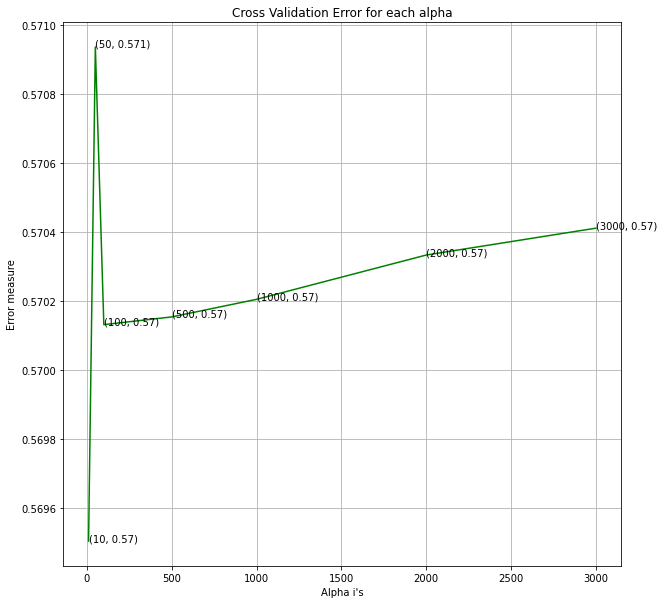

CPU times: user 14min 39s, sys: 34.9 s, total: 15min 14s
Wall time: 5min


In [ ]:
%%time
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss

alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
train_log_error_array=[]

for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(pixel_train,train_labels)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(pixel_train, train_labels)
    predict_y = sig_clf.predict_proba(pixel_test)
    cv_log_error_array.append(log_loss(test_labels, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
plt.figure(figsize=(10,10))
plt.plot(alpha, cv_log_error_array,c='g')

for i, txt in enumerate(np.round(cv_log_error_array,3)):
    plt.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))

plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [ ]:
%%time
plt.close()
r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(imp_bytes_train,train_labels)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(imp_bytes_train,train_labels)

predict_y = sig_clf.predict_proba(imp_bytes_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_labels, predict_y))
#predict_y = sig_clf.predict_proba(X_cv_merge)
#print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv_merge, predict_y))
predict_y = sig_clf.predict_proba(imp_bytes_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_labels, predict_y))

For values of best alpha =  10 The train log loss is: 1.9361837129218433
For values of best alpha =  10 The test log loss is: 1.8996045391436003
CPU times: user 4.77 s, sys: 105 ms, total: 4.87 s
Wall time: 3.27 s


Number of misclassified points  72.93002509060497
-------------------------------------------------- Confusion matrix --------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


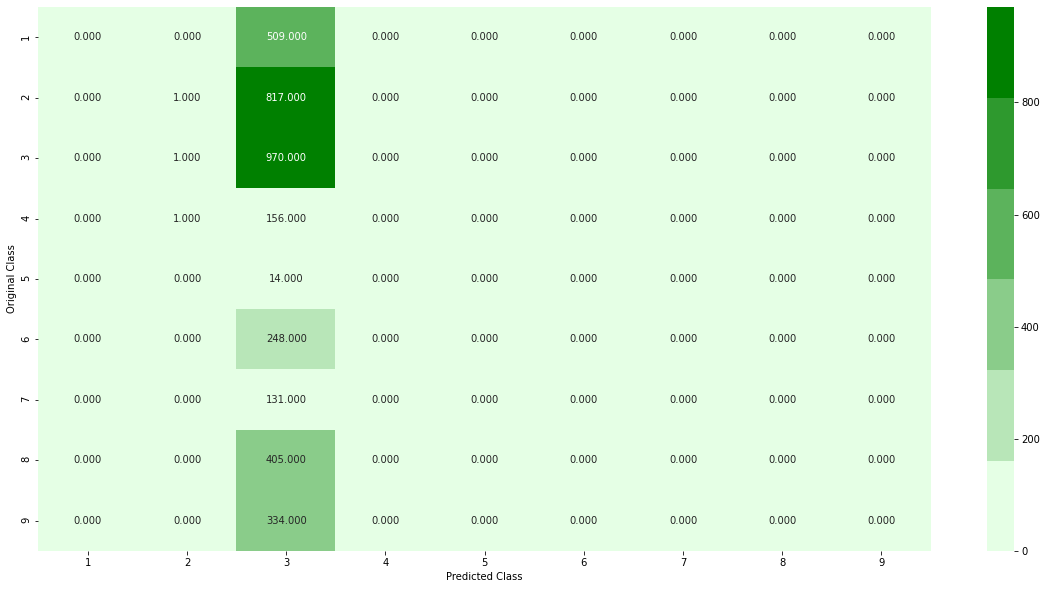

-------------------------------------------------- Precision matrix --------------------------------------------------


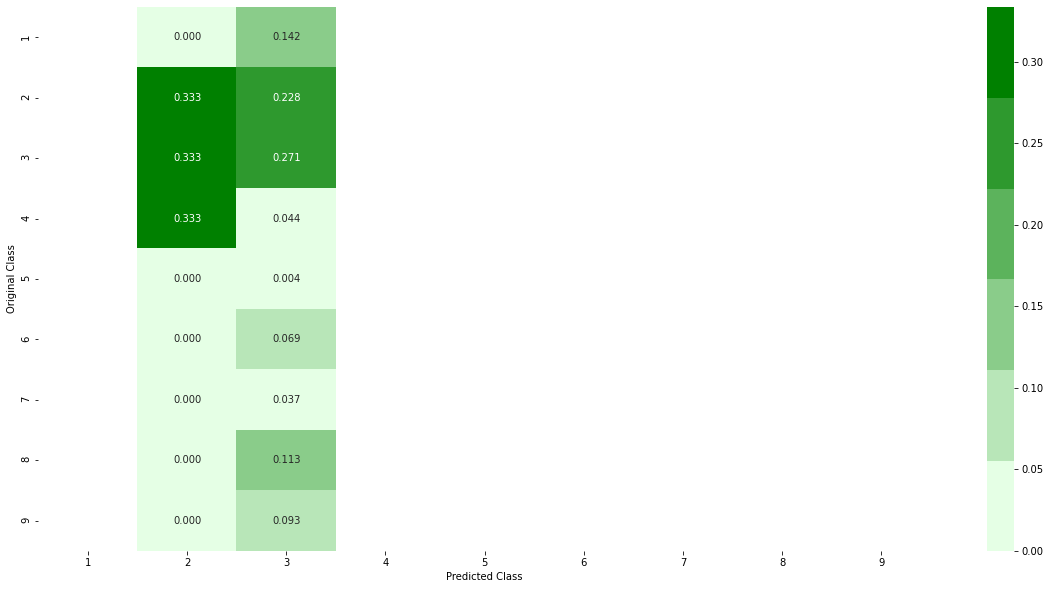

Sum of columns in precision matrix [nan  1.  1. nan nan nan nan nan nan]
-------------------------------------------------- Recall matrix --------------------------------------------------


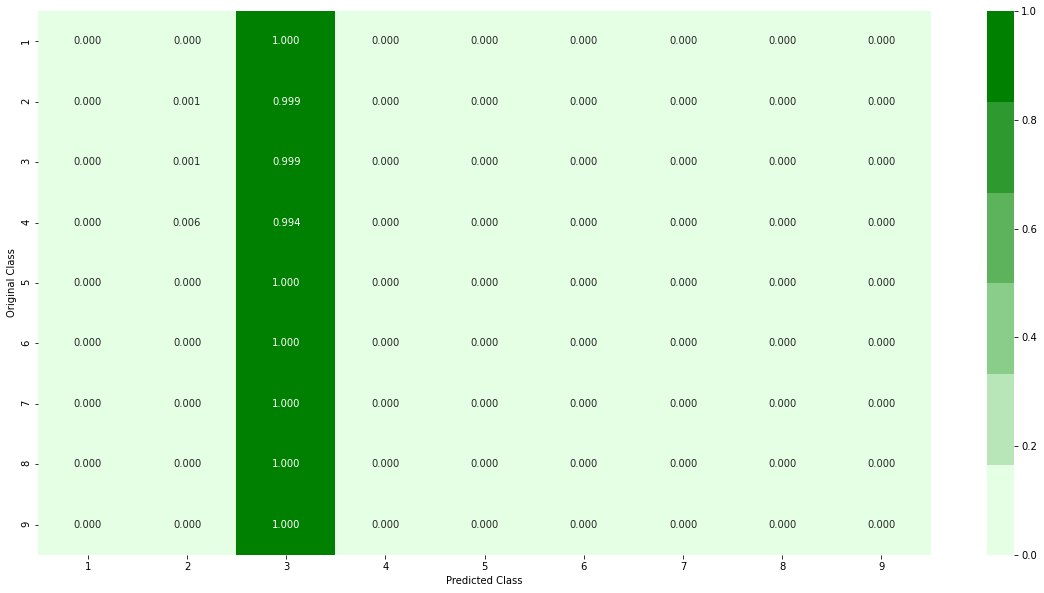

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.close()
plot_confusion_matrix(test_labels,sig_clf.predict(imp_bytes_test))

## KNN

log_loss for k =  1 is 0.8017944634002552
log_loss for k =  3 is 0.6715982675250824
log_loss for k =  5 is 0.6333181977901189
log_loss for k =  7 is 0.610988871217583
log_loss for k =  9 is 0.6109974635423208
log_loss for k =  11 is 0.5953445434051842
log_loss for k =  13 is 0.6038109128889131
log_loss for k =  15 is 0.602554740715784
log_loss for k =  17 is 0.6053767209449705
log_loss for k =  19 is 0.6032624220733595


<Figure size 720x720 with 0 Axes>

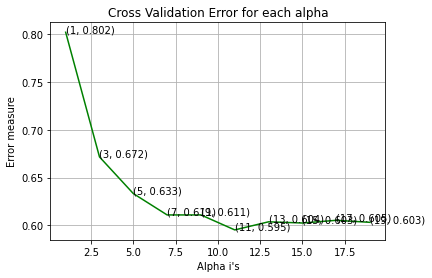

log loss for train data 0.5877861111113453
log loss for test data 0.5953445434051842
Number of misclassified points  24.031223863953162
-------------------------------------------------- Confusion matrix --------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


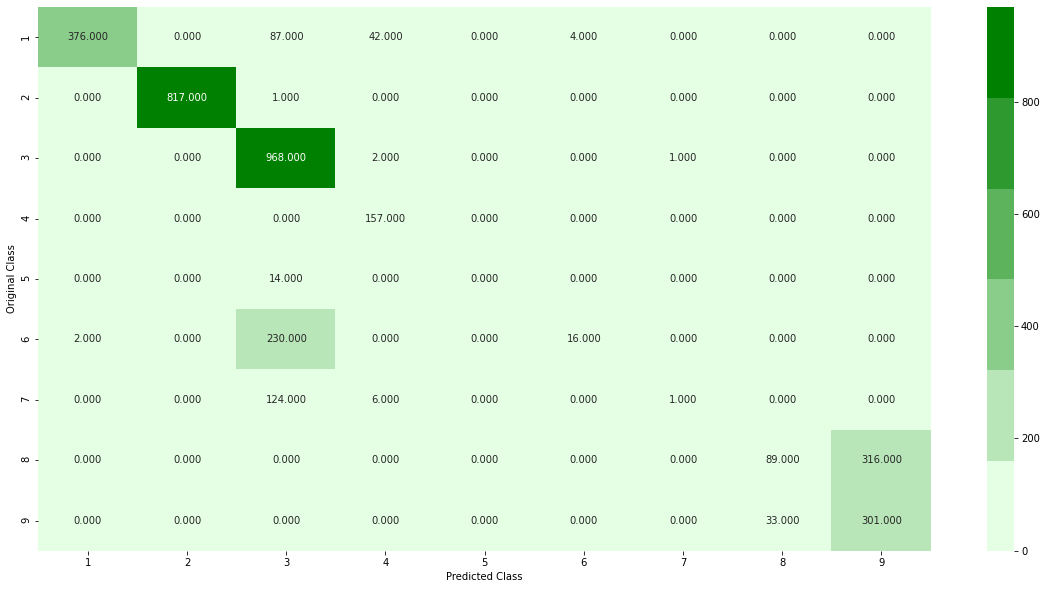

-------------------------------------------------- Precision matrix --------------------------------------------------


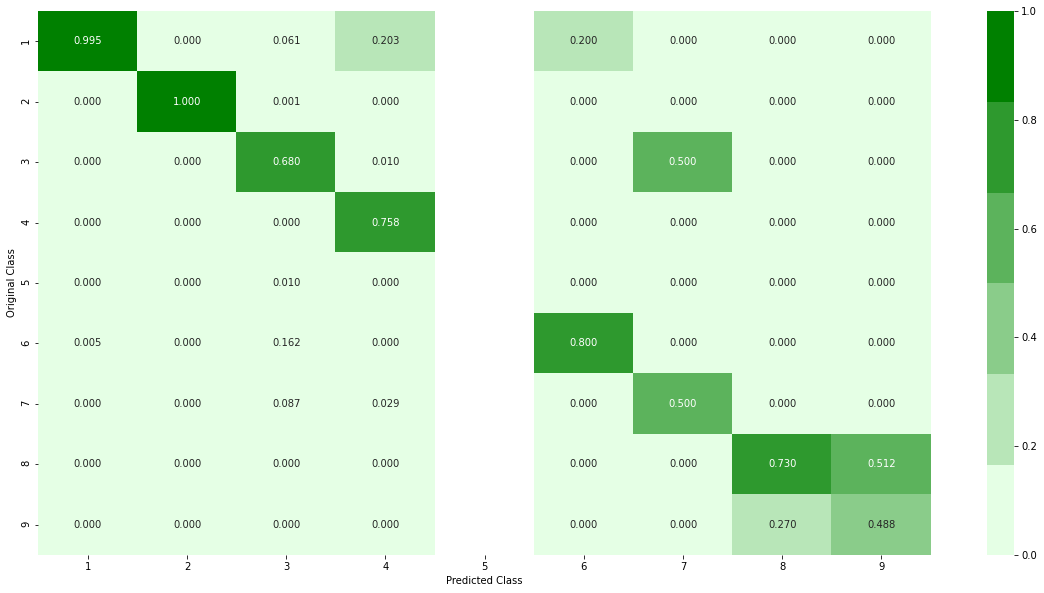

Sum of columns in precision matrix [ 1.  1.  1.  1. nan  1.  1.  1.  1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


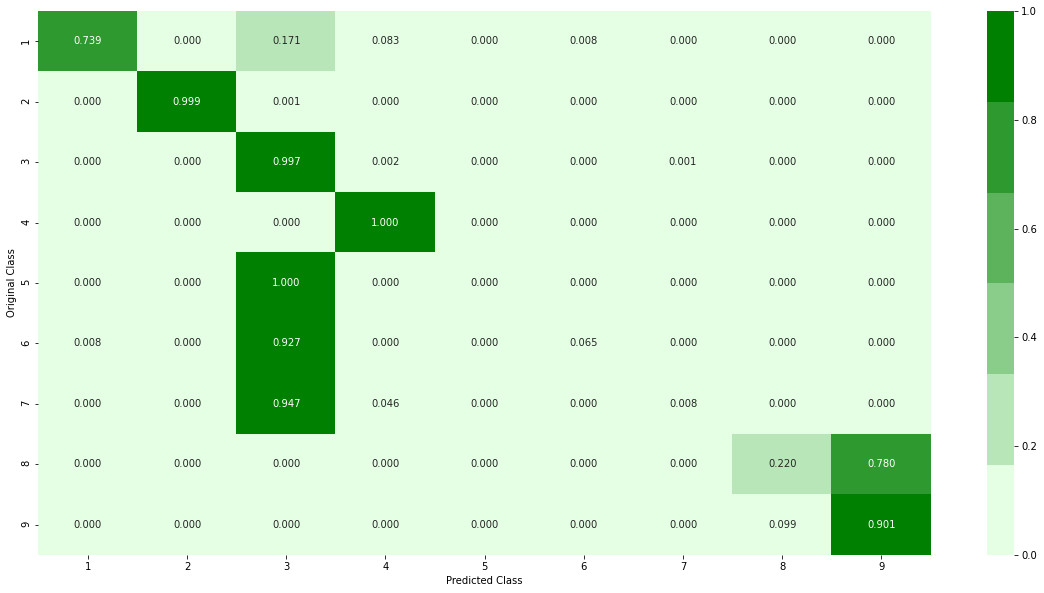

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
# find more about KNeighborsClassifier() here http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# -------------------------
# default parameter
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
# metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

# methods of
# fit(X, y) : Fit the model using X as training data and y as target values
# predict(X):Predict the class labels for the provided data
# predict_proba(X):Return probability estimates for the test data X.
#-------------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/k-nearest-neighbors-geometric-intuition-with-a-toy-example-1/
#-------------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------
from sklearn.neighbors import KNeighborsClassifier

alpha = [x for x in range(1, 21,2)]
cv_log_error_array=[]
for i in alpha:
    k_cfl=KNeighborsClassifier(n_neighbors=i)
    k_cfl.fit(pixel_train,train_labels)
    sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
    sig_clf.fit(pixel_train, train_labels)
    predict_y = sig_clf.predict_proba(pixel_test)
    cv_log_error_array.append(log_loss(test_labels, predict_y, labels=k_cfl.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for k = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)

plt.figure(figsize=(10,10))
    
fig = plt.subplots()
plt.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    plt.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

k_cfl=KNeighborsClassifier(n_neighbors=alpha[best_alpha])
k_cfl.fit(pixel_train,train_labels)
sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
sig_clf.fit(pixel_train, train_labels)
pred_y=sig_clf.predict(pixel_test)


predict_y = sig_clf.predict_proba(pixel_train)
print ('log loss for train data',log_loss(train_labels, predict_y))
#predict_y = sig_clf.predict_proba(X_cv_asm)
#print ('log loss for cv data',log_loss(y_cv_asm, predict_y))
predict_y = sig_clf.predict_proba(pixel_test)
print ('log loss for test data',log_loss(test_labels, predict_y))
plot_confusion_matrix(test_labels,sig_clf.predict(pixel_test))

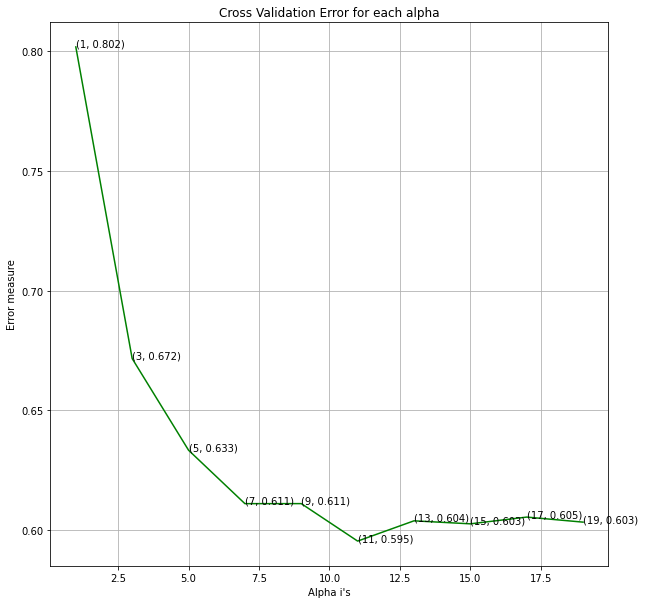

In [ ]:
best_alpha = np.argmin(cv_log_error_array)

plt.figure(figsize=(10,10))

plt.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    plt.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))

plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

# ASM + Bytes modelling

## Get data

In [ ]:
pixel_array.head()

,pix1,pix2,pix3,pix4,pix5,pix6,pix7,pix8,pix9,pix10,pix11,pix12,pix13,pix14,pix15,pix16,pix17,pix18,pix19,pix20,pix21,pix22,pix23,pix24,pix25,pix26,pix27,pix28,pix29,pix30,pix31,pix32,pix33,pix34,pix35,pix36,pix37,pix38,pix39,pix40,...,pix761,pix762,pix763,pix764,pix765,pix766,pix767,pix768,pix769,pix770,pix771,pix772,pix773,pix774,pix775,pix776,pix777,pix778,pix779,pix780,pix781,pix782,pix783,pix784,pix785,pix786,pix787,pix788,pix789,pix790,pix791,pix792,pix793,pix794,pix795,pix796,pix797,pix798,pix799,pix800
0,0.010268,0.008033,0.008320,0.007913,0.008107,0.010204,0.009955,0.009506,0.009249,0.009789,0.009422,0.009592,0.009592,0.009592,0.010854,0.009582,0.009564,0.009549,0.009592,0.009592,0.005025,0.005025,0.010471,0.006530,0.005449,0.010567,0.010543,0.009751,0.010868,0.010890,0.010460,0.00738,0.007155,0.006451,0.007008,0.009020,0.009589,0.009592,0.009407,0.009593,...,0.001358,0.007929,0.004434,0.010599,0.009311,0.008227,0.008202,0.008916,0.008844,0.008555,0.008353,0.010589,0.009222,0.008229,0.008472,0.008577,0.007968,0.008147,0.008478,0.008505,0.009610,0.009617,0.011791,0.009728,0.009394,0.008258,0.010045,0.009446,0.009417,0.009470,0.007845,0.007574,0.008736,0.008160,0.007434,0.009323,0.007726,0.007915,0.008179,0.007428
1,0.006560,0.013504,0.012927,0.013963,0.013629,0.007218,0.008239,0.009506,0.010020,0.009036,0.009618,0.009592,0.009592,0.009592,0.002035,0.009582,0.009564,0.009549,0.009592,0.009592,0.017867,0.017867,0.005679,0.016075,0.017437,0.004696,0.004890,0.008850,0.002078,0.001578,0.005868,0.01476,0.015055,0.016127,0.015634,0.010899,0.009589,0.009592,0.010191,0.009593,...,0.004828,0.007795,0.004434,0.013901,0.016943,0.015375,0.015596,0.014177,0.014208,0.015146,0.013830,0.001562,0.015269,0.016188,0.014028,0.013920,0.015284,0.015493,0.013482,0.013665,0.017014,0.015923,0.006186,0.016267,0.017095,0.015432,0.005269,0.008672,0.007410,0.007918,0.007202,0.006705,0.004583,0.005351,0.009749,0.010545,0.005193,0.001687,0.001341,0.005602
2,0.010268,0.008033,0.008320,0.007913,0.008107,0.010204,0.009955,0.009506,0.009249,0.009789,0.009422,0.009592,0.009592,0.009592,0.010854,0.009582,0.009564,0.009549,0.009592,0.009592,0.005025,0.005025,0.010471,0.006530,0.005449,0.010567,0.010543,0.009751,0.010868,0.010890,0.010460,0.00738,0.007155,0.006451,0.007008,0.009020,0.009589,0.009592,0.009407,0.009593,...,0.001358,0.007929,0.004434,0.010599,0.009311,0.008227,0.008202,0.008916,0.008844,0.008555,0.008353,0.010589,0.009222,0.008229,0.008472,0.008577,0.007968,0.008147,0.008478,0.008505,0.009610,0.009617,0.011791,0.009728,0.009394,0.008258,0.010045,0.009446,0.009417,0.009470,0.007845,0.007574,0.008736,0.008160,0.007434,0.009323,0.007726,0.007915,0.008179,0.007428
3,0.010268,0.008033,0.008320,0.007913,0.008107,0.010204,0.009955,0.009704,0.009249,0.009036,0.009422,0.009592,0.009592,0.009592,0.010854,0.009582,0.009564,0.009549,0.009592,0.009592,0.005025,0.005025,0.010471,0.006530,0.005449,0.010567,0.010543,0.009751,0.010868,0.010890,0.010460,0.00738,0.007304,0.006451,0.006469,0.009020,0.009589,0.009592,0.009407,0.009593,...,0.016446,0.014649,0.016626,0.002259,0.001526,0.009711,0.009277,0.009500,0.009859,0.009677,0.011229,0.010069,0.007408,0.006475,0.006667,0.006749,0.006270,0.006411,0.006672,0.006693,0.001418,0.001419,0.001740,0.001435,0.001386,0.001218,0.001482,0.001394,0.001389,0.007141,0.014018,0.013783,0.014322,0.013511,0.013161,0.004891,0.012918,0.014013,0.013007,0.014126
4,0.010268,0.008033,0.008320,0.007913,0.008107,0.010204,0.009955,0.009506,0.009249,0.009789,0.009422,0.009592,0.009592,0.009592,0.010854,0.009582,0.009564,0.009549,0.009592,0.009592,0.005025,0.005025,0.010471,0.006530,0.005449,0.010567,0.010543,0.009751,0.010868,0.010890,0.010460,0.00738,0.007155,0.006451,0.007008,0.009020,0.009589,0.009592,0.009407,0.009593,...,0.001358,0.007929,0.004434,0.010599,0.009311,0.008227,0.008202,0.008916,0.008844,0.008555,0.008353,0.010589,0.009222,0.008229,0.008472,0.008577,0.007968,0.008147,0.008478,0.008505,0.009610,0.009617,0.011791,0.009728,0.0

In [ ]:
import pickle

pixel_array = pickle.load(open('/content/gdrive/My Drive/Colab Notebooks/Malware uploads/pixel_array.pkl', 'rb'))

In [ ]:
from scipy import sparse

byte_matrix = sparse.load_npz('/content/gdrive/My Drive/Colab Notebooks/Malware uploads/normalized_byte.npz')

In [ ]:
byte_matrix = byte_matrix.todense()

In [ ]:
import pandas as pd

byte_matrix = pd.DataFrame(byte_matrix)

In [ ]:
byte_matrix['Id'] = y_for_bytes['Id']

In [ ]:
byte_matrix = pd.merge(byte_matrix, pixel_array, on='Id')

In [ ]:
y = byte_matrix['Class']
byte_matrix = byte_matrix.drop(['Class'], axis=1)
byte_matrix = byte_matrix.drop(['Id'],axis=1)

In [ ]:
byte_matrix.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,pix761,pix762,pix763,pix764,pix765,pix766,pix767,pix768,pix769,pix770,pix771,pix772,pix773,pix774,pix775,pix776,pix777,pix778,pix779,pix780,pix781,pix782,pix783,pix784,pix785,pix786,pix787,pix788,pix789,pix790,pix791,pix792,pix793,pix794,pix795,pix796,pix797,pix798,pix799,pix800
0,0.039942,0.011291,0.011275,0.020275,0.013486,0.016280,0.018889,0.021369,0.014631,0.022283,0.019937,0.021955,0.024324,0.020127,0.010222,0.015997,0.015103,0.021254,0.010047,0.006589,0.022651,0.015036,0.004895,0.011754,0.016227,0.007120,0.022560,0.023194,0.009484,0.049598,0.013713,0.009963,0.010302,0.016755,0.013926,0.031437,0.026444,0.019645,0.006323,0.007683,...,0.001358,0.007929,0.004434,0.010599,0.009311,0.008227,0.008202,0.008916,0.008844,0.008555,0.008353,0.010589,0.009222,0.008229,0.008472,0.008577,0.007968,0.008147,0.008478,0.008505,0.009610,0.009617,0.011791,0.009728,0.009394,0.008258,0.010045,0.009446,0.009417,0.009470,0.007845,0.007574,0.008736,0.008160,0.007434,0.009323,0.007726,0.007915,0.008179,0.007428
1,0.003536,0.007678,0.000942,0.000695,0.002218,0.000202,0.000086,0.000176,0.000563,0.000185,0.000255,0.000160,0.000427,0.000333,0.000051,0.000888,0.005905,0.000161,0.030522,0.000017,0.000256,0.000057,0.000755,0.000000,0.000270,0.000034,0.000243,0.000050,0.000122,0.000272,0.000106,0.000041,0.006462,0.000126,0.000192,0.000460,0.000436,0.000200,0.000141,0.000220,...,0.004828,0.007795,0.004434,0.013901,0.016943,0.015375,0.015596,0.014177,0.014208,0.015146,0.013830,0.001562,0.015269,0.016188,0.014028,0.013920,0.015284,0.015493,0.013482,0.013665,0.017014,0.015923,0.006186,0.016267,0.017095,0.015432,0.005269,0.008672,0.007410,0.007918,0.007202,0.006705,0.004583,0.005351,0.009749,0.010545,0.005193,0.001687,0.001341,0.005602
2,0.002930,0.006832,0.002296,0.002568,0.007512,0.011796,0.009488,0.003188,0.009197,0.003521,0.003291,0.002987,0.010164,0.003414,0.001603,0.003702,0.002790,0.005280,0.001355,0.001515,0.003442,0.002771,0.000933,0.001668,0.003745,0.001165,0.003422,0.004629,0.001347,0.007014,0.002429,0.001755,0.002092,0.002927,0.003691,0.003243,0.002800,0.002617,0.001024,0.001462,...,0.001358,0.007929,0.004434,0.010599,0.009311,0.008227,0.008202,0.008916,0.008844,0.008555,0.008353,0.010589,0.009222,0.008229,0.008472,0.008577,0.007968,0.008147,0.008478,0.008505,0.009610,0.009617,0.011791,0.009728,0.009394,0.008258,0.010045,0.009446,0.009417,0.009470,0.007845,0.007574,0.008736,0.008160,0.007434,0.009323,0.007726,0.007915,0.008179,0.007428
3,0.001748,0.002328,0.000839,0.001123,0.001464,0.000646,0.000311,0.000440,0.000879,0.000324,0.000425,0.000301,0.001203,0.000271,0.000143,0.001058,0.003066,0.000590,0.000057,0.000069,0.000907,0.000227,0.000042,0.000111,0.000374,0.000060,0.000155,0.000175,0.000245,0.000317,0.000158,0.000176,0.001920,0.000090,0.000157,0.000048,0.000726,0.000509,0.000013,0.000076,...,0.016446,0.014649,0.016626,0.002259,0.001526,0.009711,0.009277,0.009500,0.009859,0.009677,0.011229,0.010069,0.007408,0.006475,0.006667,0.006749,0.006270,0.006411,0.006672,0.006693,0.001418,0.001419,0.001740,0.001435,0.001386,0.001218,0.001482,0.001394,0.001389,0.007141,0.014018,0.013783,0.014322,0.013511,0.013161,0.004891,0.012918,0.014013,0.013007,0.014126
4,0.002732,0.000648,0.000265,0.001890,0.000118,0.000182,0.000052,0.000110,0.000123,0.000046,0.000000,0.000060,0.000136,0.000000,0.000041,0.000264,0.000081,0.000054,0.000010,0.000035,0.000093,0.000000,0.000010,0.000022,0.000104,0.000119,0.000088,0.000050,0.000000,0.000045,0.000000,0.000052,0.000079,0.000018,0.000070,0.000048,0.000083,0.000091,0.000007,0.000038,...,0.001358,0.007929,0.004434,0.010599,0.009311,0.008227,0.008202,0.008916,0.008844,0.008555,0.008353,0.010589,0.009222,0.008229,0.008472,0.008577,0.007968,0.008147,0.008478,0.008505,0.009610,0.009617,0.011791,0.009728,0.009394,0.008258,0.010045,0.009446,0.009417,0.009470,0.007845,0.007574,0.008736,0.008160,0.007434,0.009323,0.007726,0.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(byte_matrix, y, test_size=0.33, stratify=y)

## Getting important features

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
import numpy as np

imp_idx = np.flip(np.argsort(rf.feature_importances_,))

In [ ]:
from tqdm import tqdm

imp_train = np.zeros((X_train.shape[0], 0))
imp_test = np.zeros((X_test.shape[0], 0))

X_train=np.asarray(X_train)
X_test = np.asarray(X_test)

for i in tqdm(imp_idx[:500]):
  train = X_train[:, i]
  train = np.reshape(train,(-1,1))
  imp_train =  np.hstack([imp_train, train])
  test = X_test[:, i]
  test = np.reshape(test,(-1,1))
  imp_test =  np.hstack([imp_test, test])

100%|██████████| 500/500 [00:02<00:00, 167.65it/s]


In [ ]:
X_train = imp_train
X_test = imp_test

## Random Forest

In [ ]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------

from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss

alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
train_log_error_array=[]
from sklearn.ensemble import RandomForestClassifier
for i in tqdm(alpha):
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    cv_log_error_array.append(log_loss(y_test, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

100%|██████████| 7/7 [06:21<00:00, 54.53s/it]

log_loss for c =  10 is 0.03440668172786475
log_loss for c =  50 is 0.030403507575896604
log_loss for c =  100 is 0.03046139460000716
log_loss for c =  500 is 0.030927244679280166
log_loss for c =  1000 is 0.030703827716705816
log_loss for c =  2000 is 0.030421135287267573
log_loss for c =  3000 is 0.03029152027742546


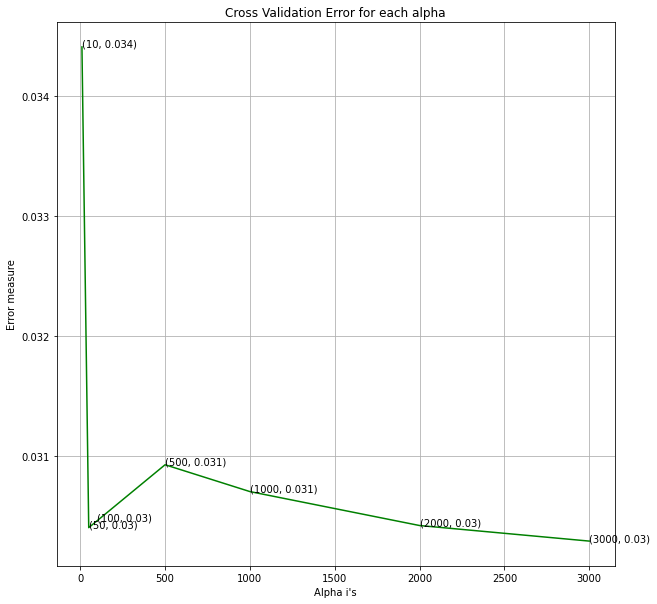

In [ ]:
import matplotlib.pyplot as plt

best_alpha = np.argmin(cv_log_error_array)
plt.figure(figsize=(10,10))

plt.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    plt.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


For values of best alpha =  3000 The train log loss is: 0.010073549906585821
For values of best alpha =  3000 The test log loss is: 0.03029152027742546
Number of misclassified points  0.7248396989127405
-------------------------------------------------- Confusion matrix --------------------------------------------------


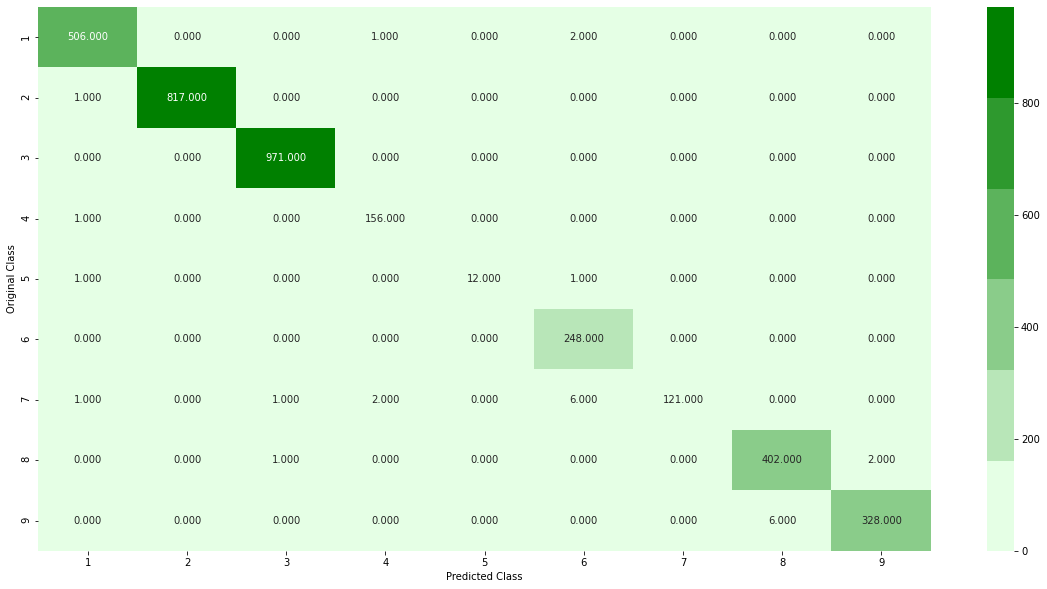

-------------------------------------------------- Precision matrix --------------------------------------------------


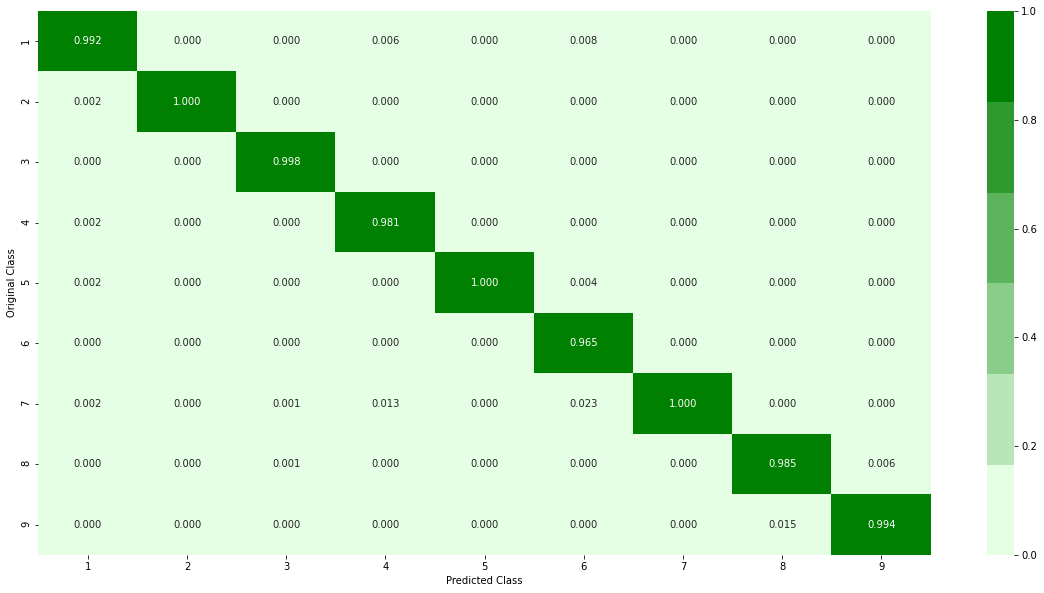

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


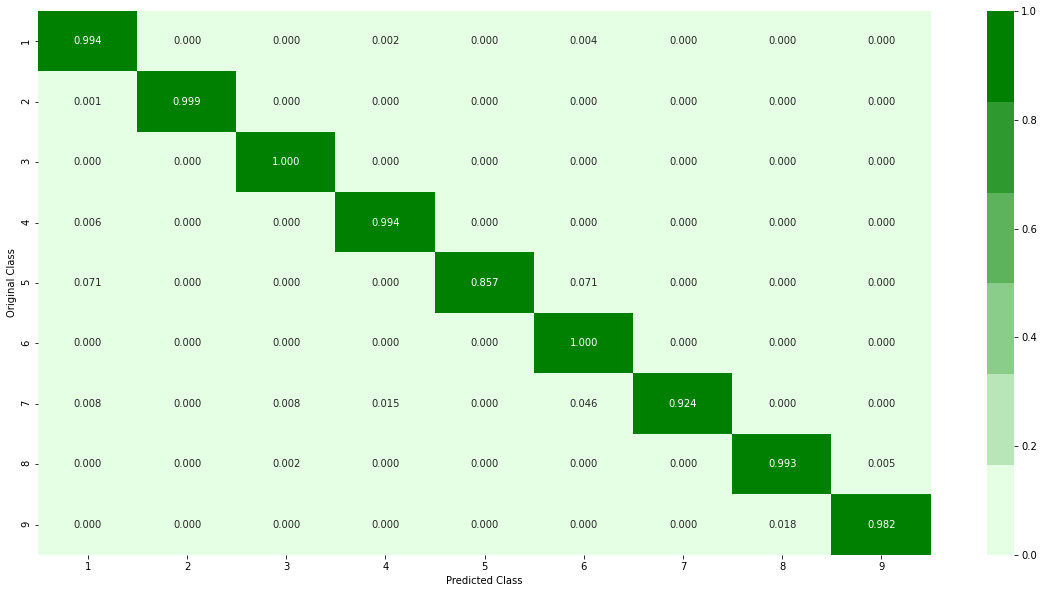

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
#predict_y = sig_clf.predict_proba(X_cv)
#print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

## XGB fully tuned

In [ ]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
# from reference notebook

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}

random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl.fit(X_train, y_train)

print(random_cfl.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 34.8min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 45.9min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 62.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 71.6min finished


{'subsample': 0.5, 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.3}


In [ ]:
%%time
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------
x_cfl=XGBClassifier(n_estimators=1000,max_depth=5,learning_rate=0.1,colsample_bytree=0.3,subsample=0.5,nthread=-1)
x_cfl.fit(X_train,y_train,verbose=True)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print ('train loss',log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print ('test loss',log_loss(y_test, predict_y))

train loss 0.010092929781847058
test loss 0.03718159601461523
CPU times: user 16min 11s, sys: 698 ms, total: 16min 12s
Wall time: 16min 12s


Number of misclassified points  0.6412043490381935
-------------------------------------------------- Confusion matrix --------------------------------------------------


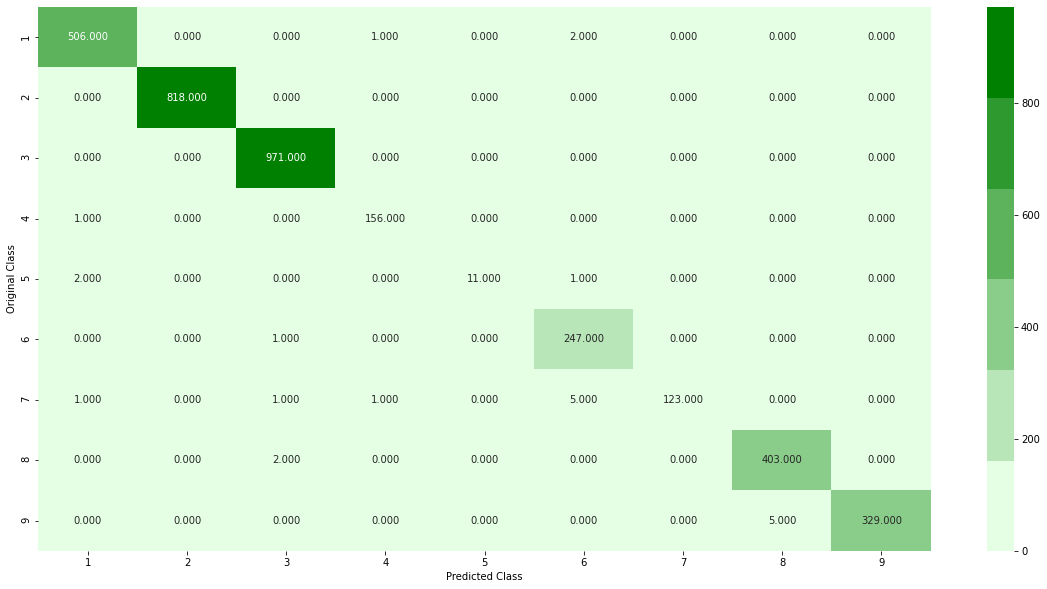

-------------------------------------------------- Precision matrix --------------------------------------------------


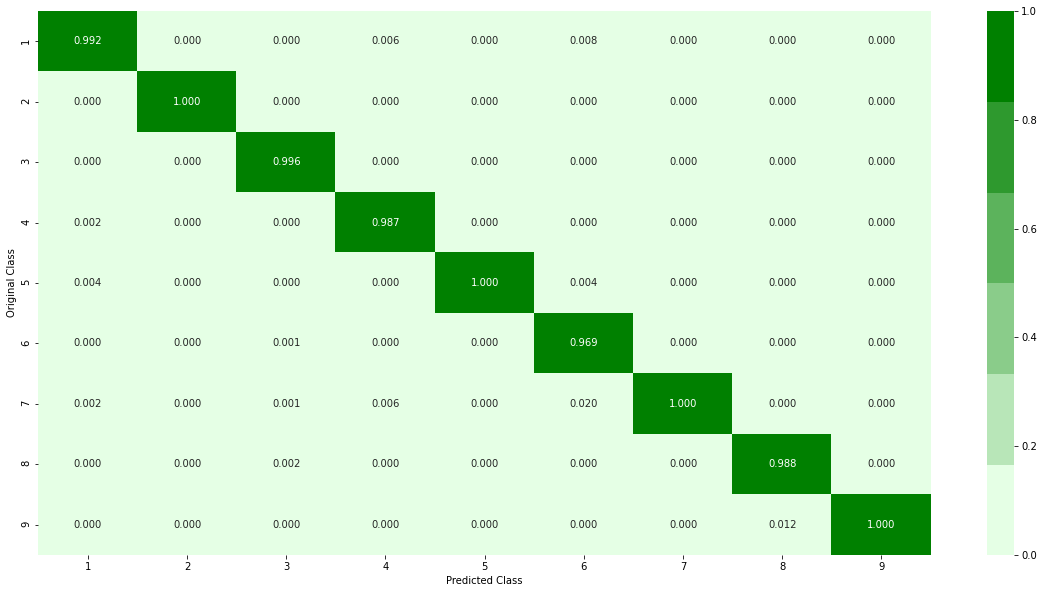

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


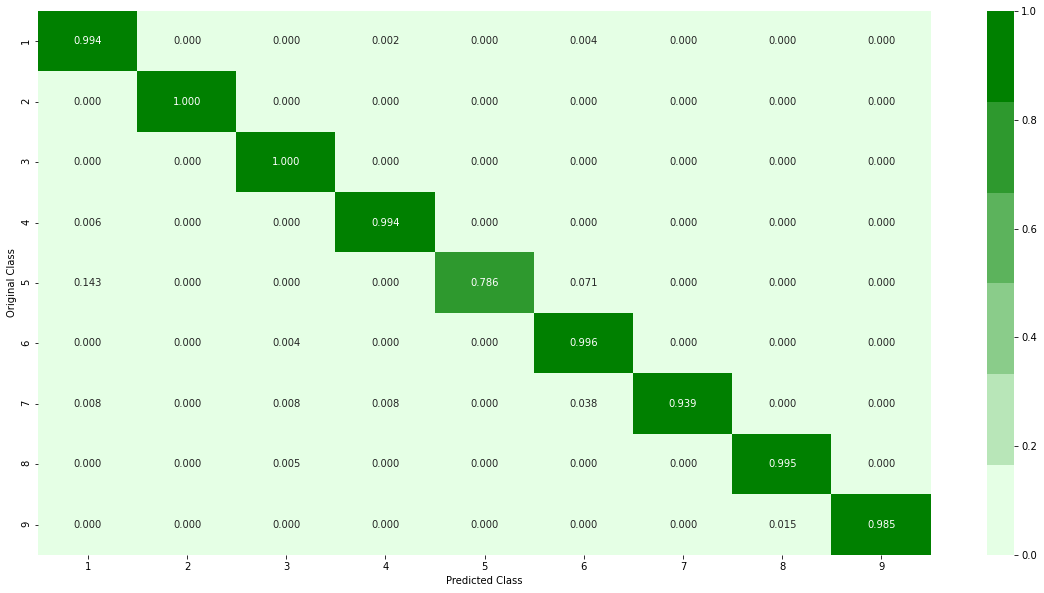

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.close()
plot_confusion_matrix(y_test,sig_clf.predict(X_test))

## KNN

log_loss for k =  1 is 0.07380266635662136
log_loss for k =  3 is 0.06962630005368621
log_loss for k =  5 is 0.07750269484090568
log_loss for k =  7 is 0.08488070724407334
log_loss for k =  9 is 0.09185876045625707
log_loss for k =  11 is 0.09771234011371012
log_loss for k =  13 is 0.10576553433917357
log_loss for k =  15 is 0.1132003222025821
log_loss for k =  17 is 0.12012741402512038
log_loss for k =  19 is 0.12590559629416118


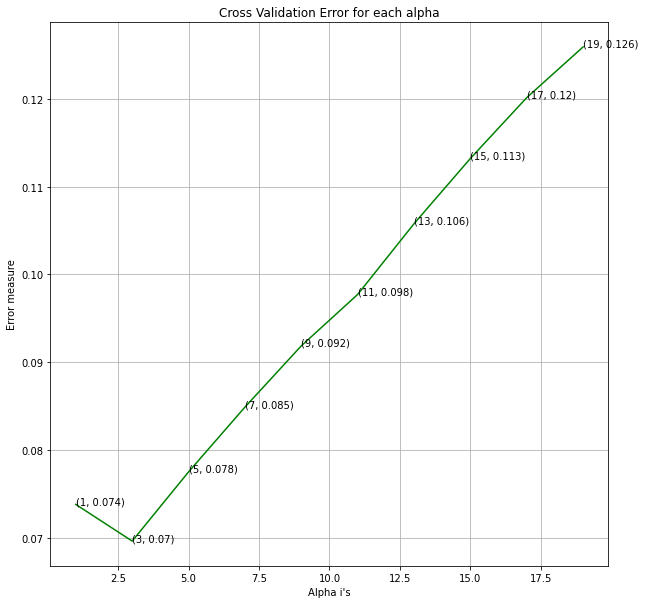

log loss for train data 0.04582354556618559
log loss for test data 0.06962630005368621
Number of misclassified points  1.5611931976582103
-------------------------------------------------- Confusion matrix --------------------------------------------------


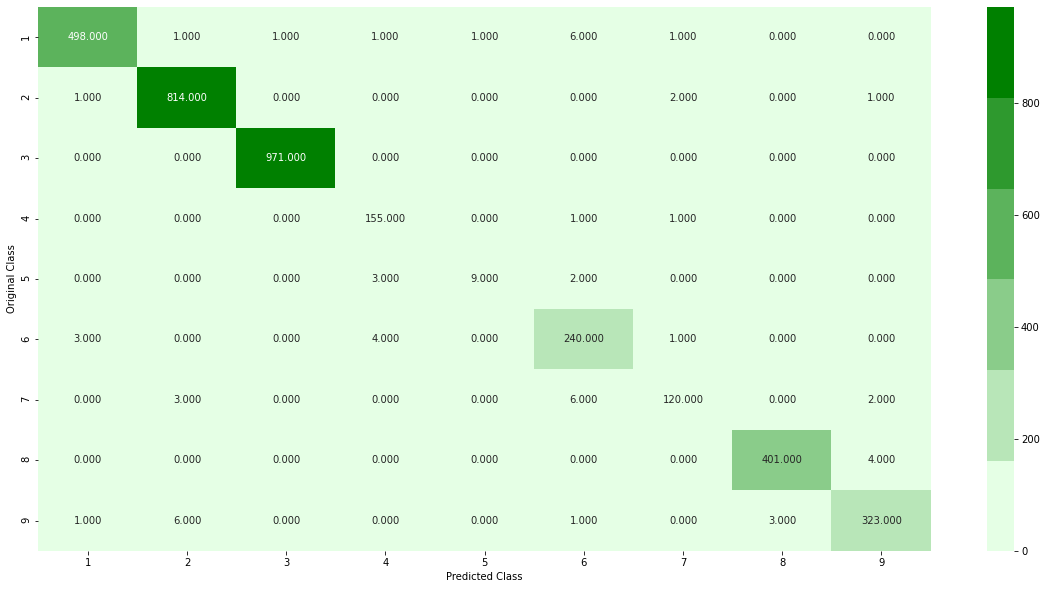

-------------------------------------------------- Precision matrix --------------------------------------------------


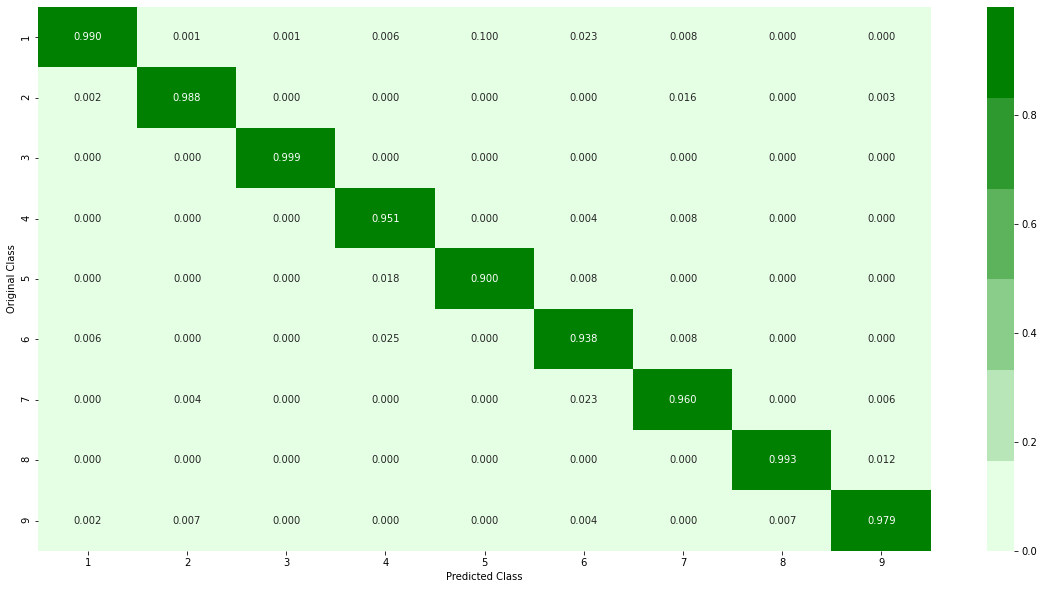

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


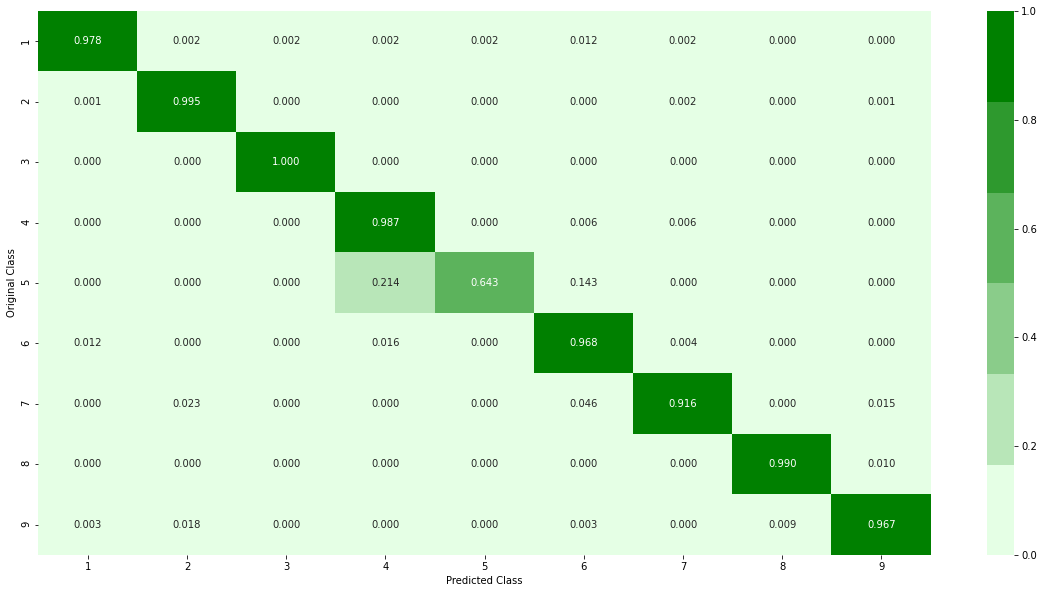

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
# find more about KNeighborsClassifier() here http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# -------------------------
# default parameter
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
# metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

# methods of
# fit(X, y) : Fit the model using X as training data and y as target values
# predict(X):Predict the class labels for the provided data
# predict_proba(X):Return probability estimates for the test data X.
#-------------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/k-nearest-neighbors-geometric-intuition-with-a-toy-example-1/
#-------------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------
from sklearn.neighbors import KNeighborsClassifier

alpha = [x for x in range(1, 21,2)]
cv_log_error_array=[]
for i in alpha:
    k_cfl=KNeighborsClassifier(n_neighbors=i)
    k_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    cv_log_error_array.append(log_loss(y_test, predict_y, labels=k_cfl.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for k = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)

plt.figure(figsize=(10,10))
    
plt.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    plt.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

k_cfl=KNeighborsClassifier(n_neighbors=alpha[best_alpha])
k_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")

sig_clf.fit(X_train, y_train)
predict_y = sig_clf.predict_proba(X_train)
print ('log loss for train data',log_loss(y_train, predict_y))
#predict_y = sig_clf.predict_proba(X_cv_asm)
#print ('log loss for cv data',log_loss(y_cv_asm, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print ('log loss for test data',log_loss(y_test, predict_y))
plot_confusion_matrix(y_test,sig_clf.predict(X_test))

# Summary of first three

##Model-1 bytes bigram

I have calculated the top 200 featues out of 66049.



        MODEL/LOSS          TRAIN           TEST           ALPHA        Misclassified points
      Random forest         0.01940        0.07318          1000               1.6448
         XGBoost            0.02217        0.07478    200\5\0.2\0.5\0.3        1.5333

## Model-2 ASM

I have modelled on all 800 features as mentioned in the reference video

        MODEL/LOSS          TRAIN           TEST           ALPHA        Misclassified points
      Random forest         1.93618        1.89960           10                73.93
           KNN              0.58778        0.59534           11                24.03

## Model-3 ASM + Bytes bigram

I have modelled on top 500 features

        MODEL/LOSS          TRAIN           TEST           ALPHA        Misclassified points
      Random forest         0.01007        0.03029          3000                0.7248
         XGBoost            0.01009        0.03718   1000\5\0.1\0.3\0.5         0.6412
           KNN              0.04582        0.06962            3                  1.56

# Model-4 ASM + Bytes with all features as mentioned

## Random Forest

In [ ]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------

from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
train_log_error_array=[]
for i in tqdm(alpha):
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    cv_log_error_array.append(log_loss(y_test, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

100%|██████████| 7/7 [1:24:40<00:00, 725.77s/it] 

log_loss for c =  10 is 0.03969856815584031
log_loss for c =  50 is 0.031132460195729825
log_loss for c =  100 is 0.0302084783811564
log_loss for c =  500 is 0.029610107454669066
log_loss for c =  1000 is 0.029614785537815092
log_loss for c =  2000 is 0.029836507720275567
log_loss for c =  3000 is 0.029700433210486106


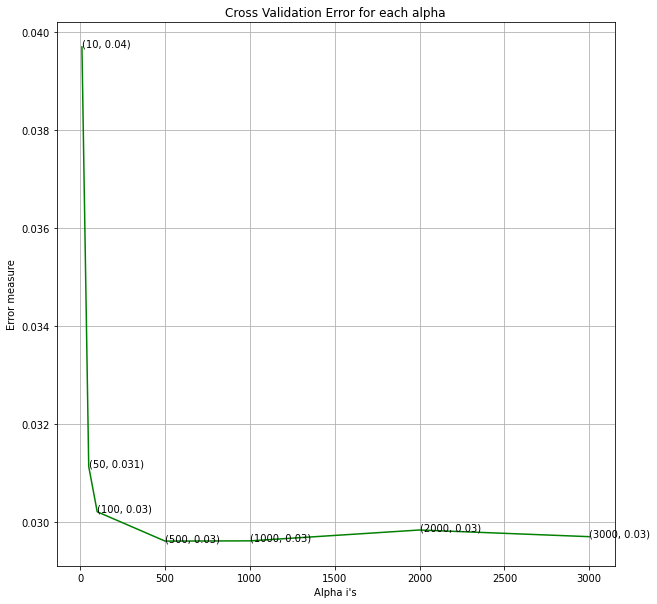

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

best_alpha = np.argmin(cv_log_error_array)
plt.figure(figsize=(10,10))

plt.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    plt.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [ ]:
# from reference notebook
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(20,10))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(20,10))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(20,10))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

For values of best alpha =  500 The train log loss is: 0.013015197333292438
For values of best alpha =  500 The test log loss is: 0.029610107454669066
Number of misclassified points  0.5575689991636464
-------------------------------------------------- Confusion matrix --------------------------------------------------


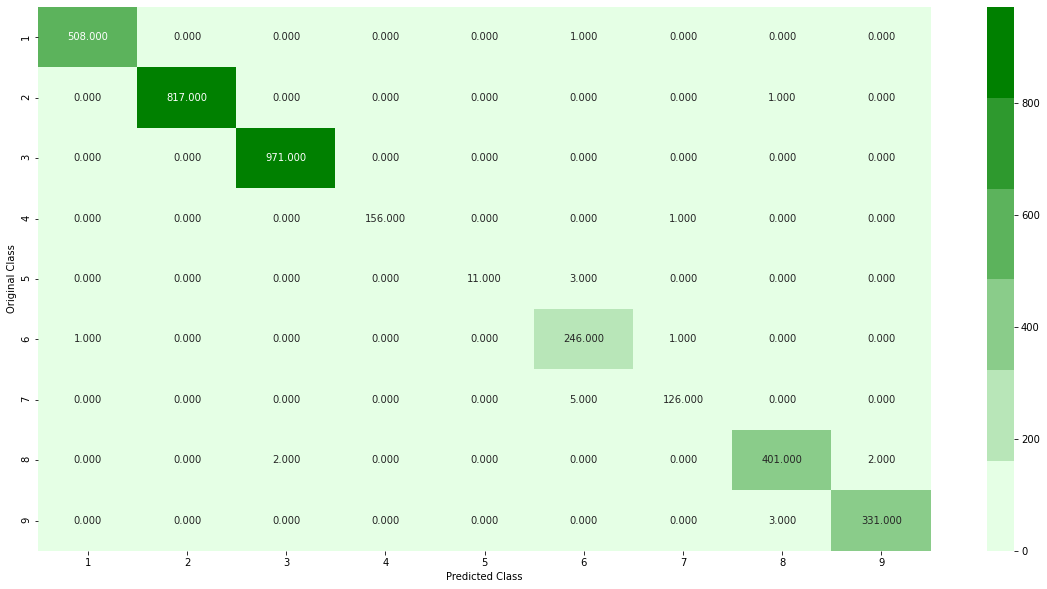

-------------------------------------------------- Precision matrix --------------------------------------------------


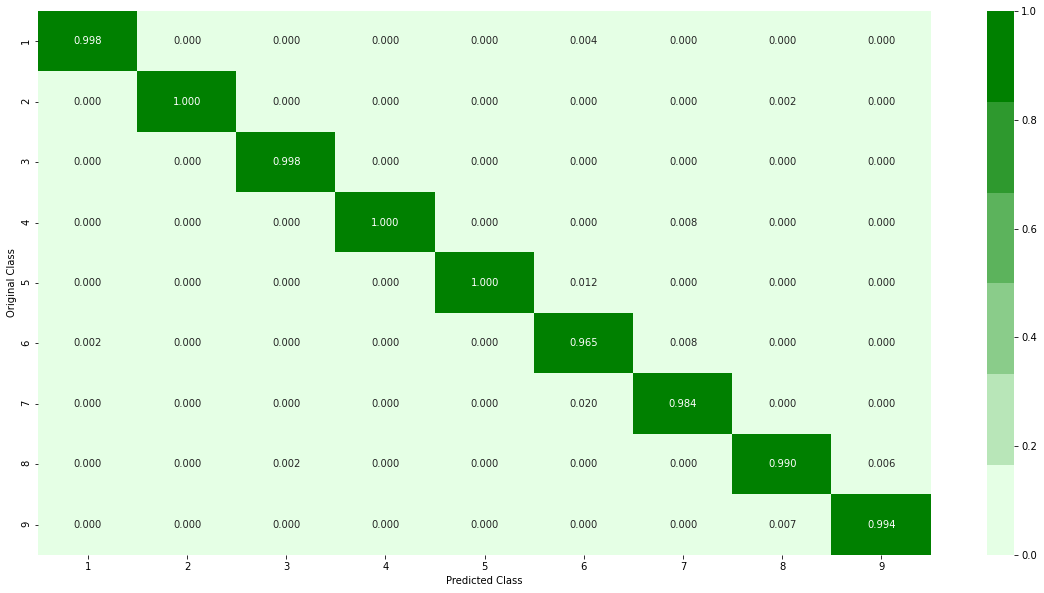

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


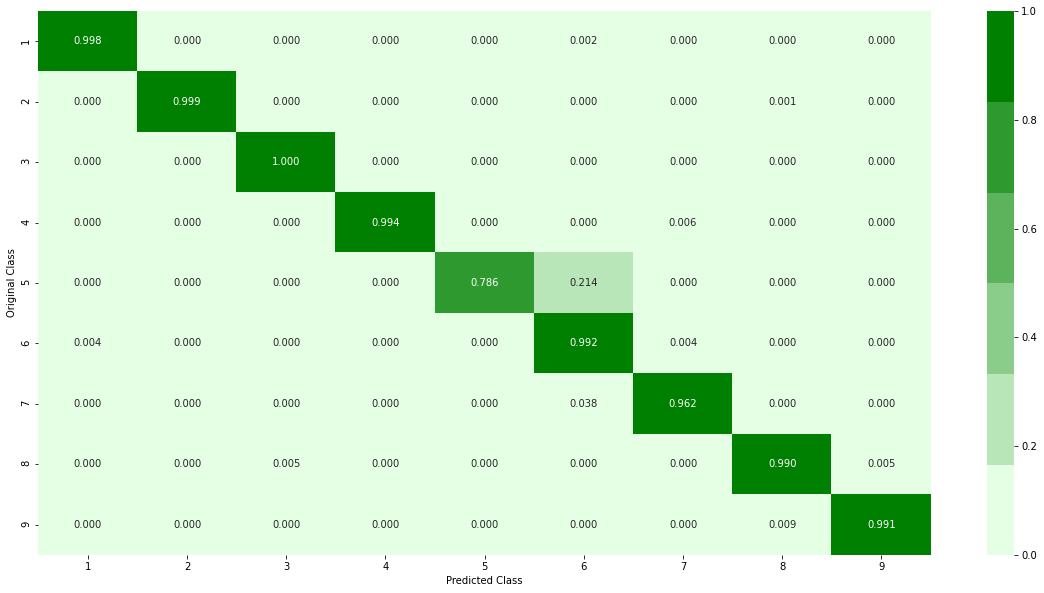

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
#predict_y = sig_clf.predict_proba(X_cv)
#print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

# Model-5: ASM + Bytes + ASM bigrams

## Get data

In [ ]:
from scipy import sparse
import pickle
import pandas as pd
from sklearn.preprocessing import normalize

print('\nLoading pixel_array and pickles')
pixel_array = pickle.load(open('/content/gdrive/My Drive/Colab Notebooks/Malware uploads/pixel_array.pkl', 'rb'))
files = pickle.load(open('/content/gdrive/My Drive/Colab Notebooks/files.pkl', 'rb'))
y_for_bytes = pickle.load(open('/content/gdrive/My Drive/Colab Notebooks/Malware uploads/y_values_for_bytes.pkl','rb'))

for i in range(len(files)):
  files[i] = files[i][53:-4]

print('\nLoading byte_matrix')
byte_matrix = sparse.load_npz('/content/gdrive/My Drive/Colab Notebooks/Malware uploads/normalized_byte.npz')
byte_matrix = byte_matrix.todense()
byte_matrix = pd.DataFrame(byte_matrix)
byte_matrix['Id'] = y_for_bytes['Id']

print('\nLoading asm_matrix')
asm_matrix = sparse.load_npz('/content/gdrive/My Drive/Colab Notebooks/opcode_bigram_vect.npz')
asm_matrix = asm_matrix.todense()
asm_matrix = normalize(asm_matrix)
asm_matrix = pd.DataFrame(asm_matrix)
asm_matrix['Id'] = files

print('\nMerging matrices')
byte_matrix = pd.merge(byte_matrix, pixel_array, on='Id')
print('\nMatrix merge summary:\n\t0 to 66049 columns belonging to byte_matrix\n\t66049 to {} belonging to pixel_array\n\t{} to {} belonging to asm_matrix'.format(66049+800, 66049+800, 66049+800+676))
byte_matrix = pd.merge(byte_matrix, asm_matrix, on='Id')

print('\nDropping class values')
y = byte_matrix['Class']
byte_matrix = byte_matrix.drop(['Class'], axis=1)
byte_matrix = byte_matrix.drop(['Id'],axis=1)


Loading pixel_array and pickles

Loading byte_matrix

Loading asm_matrix

Merging matrices

Matrix merge summary:
	0 to 66049 columns belonging to byte_matrix
	66049 to 66849 belonging to pixel_array
	66849 to 67525 belonging to asm_matrix

Dropping class values


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(byte_matrix, y, test_size=0.2, stratify=y)

In [ ]:
X_train.shape, X_test.shape

## Random Forest

In [ ]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------

from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
from tqdm import tqdm

alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
train_log_error_array=[]
from sklearn.ensemble import RandomForestClassifier
for i in tqdm(alpha):
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    cv_log_error_array.append(log_loss(y_test, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

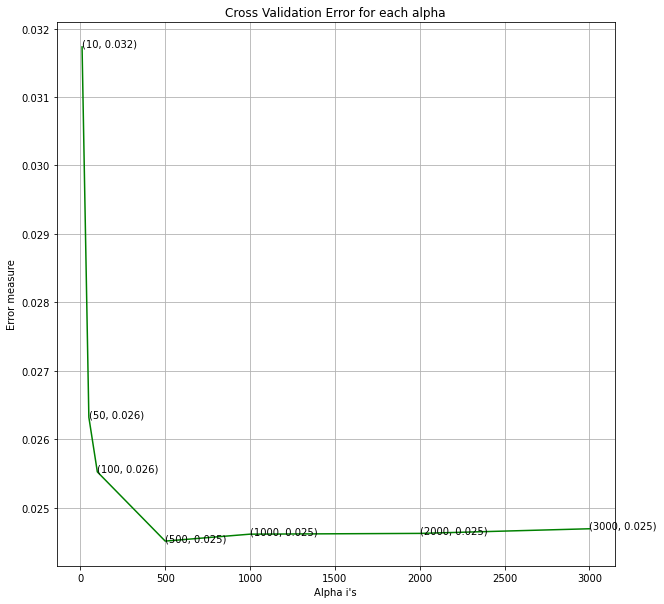

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

best_alpha = np.argmin(cv_log_error_array)
plt.figure(figsize=(10,10))

plt.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    plt.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  500 The train log loss is: 0.011244992733502074
For values of best alpha =  500 The test log loss is: 0.024509965591054683
Number of misclassified points  0.5059797608095675
-------------------------------------------------- Confusion matrix --------------------------------------------------


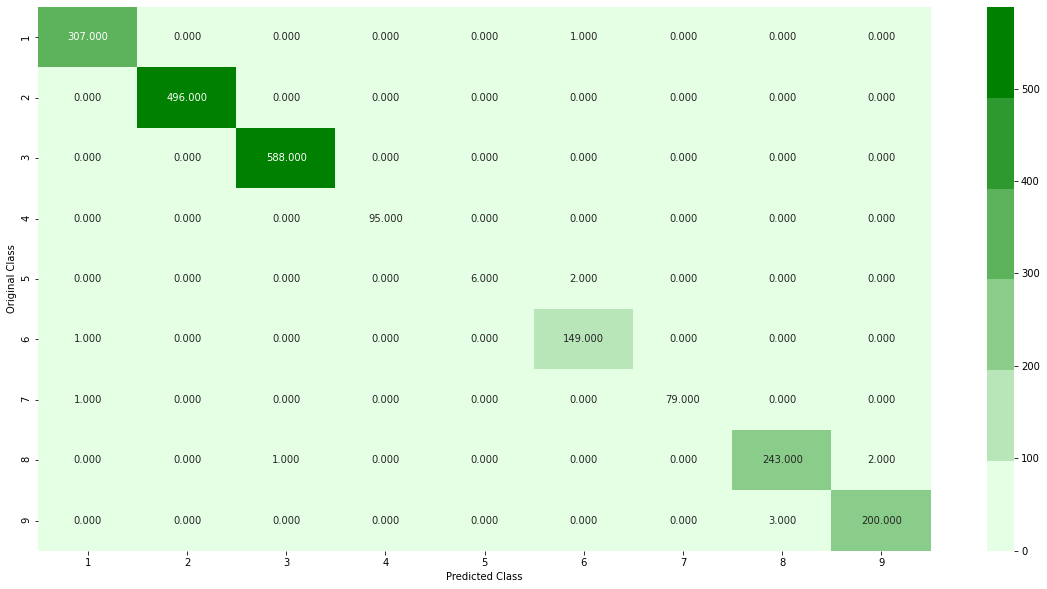

-------------------------------------------------- Precision matrix --------------------------------------------------


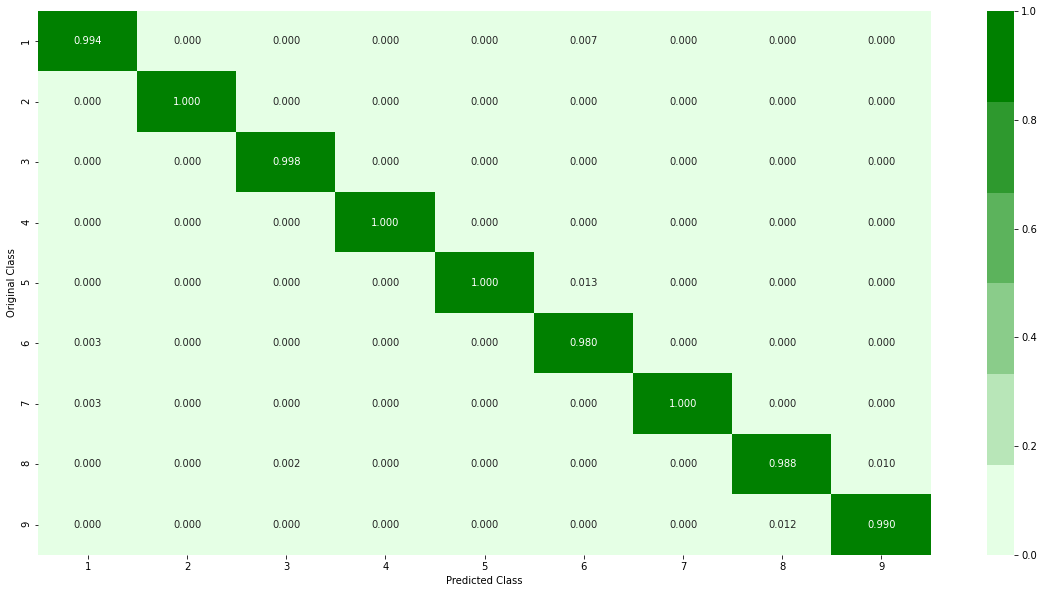

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


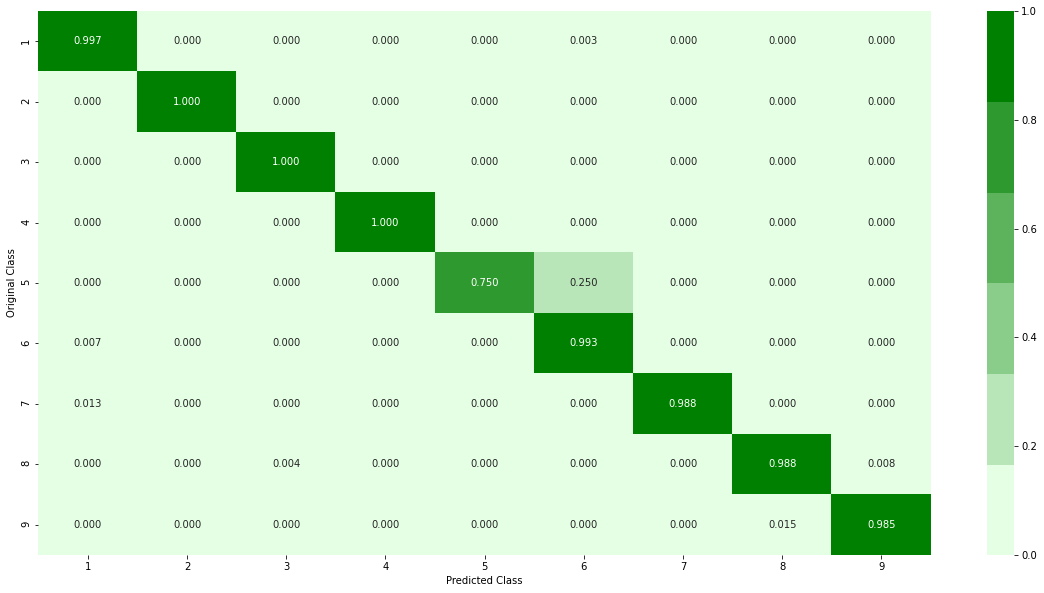

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
#r_cfl.fit(X_train,y_train)
#sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
#sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
#predict_y = sig_clf.predict_proba(X_cv)
#print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

## XGBoost

In [ ]:
import numpy as np

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)

byte_train = X_train[:,:66049]
pixel_train = X_train[:,66049:66849]
asm_train = X_train[:,66849:]

byte_test = X_test[:,:66049]
pixel_test = X_test[:,66049:66849]
asm_test = X_test[:,66849:]

byte_train.shape, pixel_train.shape, asm_train.shape, y_train.shape,byte_test.shape, pixel_test.shape, asm_test.shape, y_test.shape

((8694, 66049),
 (8694, 800),
 (8694, 676),
 (8694,),
 (2174, 66049),
 (2174, 800),
 (2174, 676),
 (2174,))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from tqdm import tqdm

rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1)
rf.fit(byte_train, y_train)

bytes_index = np.flip(np.argsort(rf.feature_importances_,)) 

imp_bytes_train = np.zeros((byte_train.shape[0], 0))
imp_bytes_test = np.zeros((byte_test.shape[0], 0))

for i in tqdm(bytes_index[:500]):
  x = byte_train[:, i]
  x = np.reshape(x,(-1,1))
  imp_bytes_train =  np.hstack([imp_bytes_train, x])
  x = byte_test[:, i]
  x = np.reshape(x,(-1,1))
  imp_bytes_test =  np.hstack([imp_bytes_test, x])

100%|██████████| 500/500 [00:02<00:00, 203.83it/s]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from tqdm import tqdm

rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1)
rf.fit(asm_train, y_train)

asm_index = np.flip(np.argsort(rf.feature_importances_,)) 

imp_asm_train = np.zeros((asm_train.shape[0], 0))
imp_asm_test = np.zeros((asm_test.shape[0], 0))

for i in tqdm(asm_index[:300]):
  x = asm_train[:, i]
  x = np.reshape(x,(-1,1))
  imp_asm_train =  np.hstack([imp_asm_train, x])
  x = asm_test[:, i]
  x = np.reshape(x,(-1,1))
  imp_asm_test =  np.hstack([imp_asm_test, x])

100%|██████████| 300/300 [00:00<00:00, 366.92it/s]


In [ ]:
imp_asm_train.shape, imp_asm_test.shape

((8694, 300), (2174, 300))

In [ ]:
X_train = np.hstack([imp_bytes_train,imp_asm_train,pixel_train])
X_test = np.hstack([imp_bytes_test,imp_asm_test,pixel_test])

In [ ]:
X_train.shape, X_test.shape

((8694, 1600), (2174, 1600))

In [ ]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
# from reference notebook

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}

random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl.fit(X_train, y_train)

print(random_cfl.best_params_) # keyboard interrupt because it was stuck

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 36.0min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 41.7min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 45.7min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 105.5min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 126.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 187.0min finished


KeyboardInterrupt: ignored

In [ ]:
print(random_cfl.best_params_)

{'subsample': 0.5, 'n_estimators': 2000, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1}


In [ ]:
%%time
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
from xgboost import XGBClassifier

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------
x_cfl=XGBClassifier(n_estimators=2000,max_depth=5,learning_rate=0.1,colsample_bytree=0.1,subsample=0.5,nthread=-1)
x_cfl.fit(X_train,y_train,verbose=True)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print ('train loss',log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print ('test loss',log_loss(y_test, predict_y))

train loss 0.008422370855573257
test loss 0.017645625387088255
CPU times: user 1h 53min 30s, sys: 2.77 s, total: 1h 53min 33s
Wall time: 28min 39s


In [9]:
# from reference notebook
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(20,10))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(20,10))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(20,10))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

Number of misclassified points  0.27598896044158233
-------------------------------------------------- Confusion matrix --------------------------------------------------


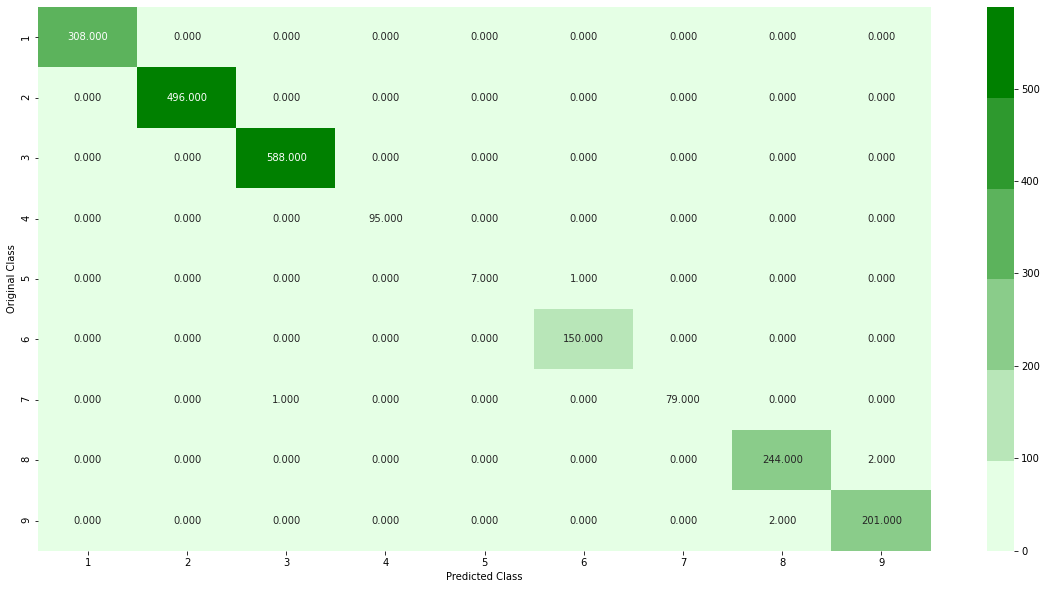

-------------------------------------------------- Precision matrix --------------------------------------------------


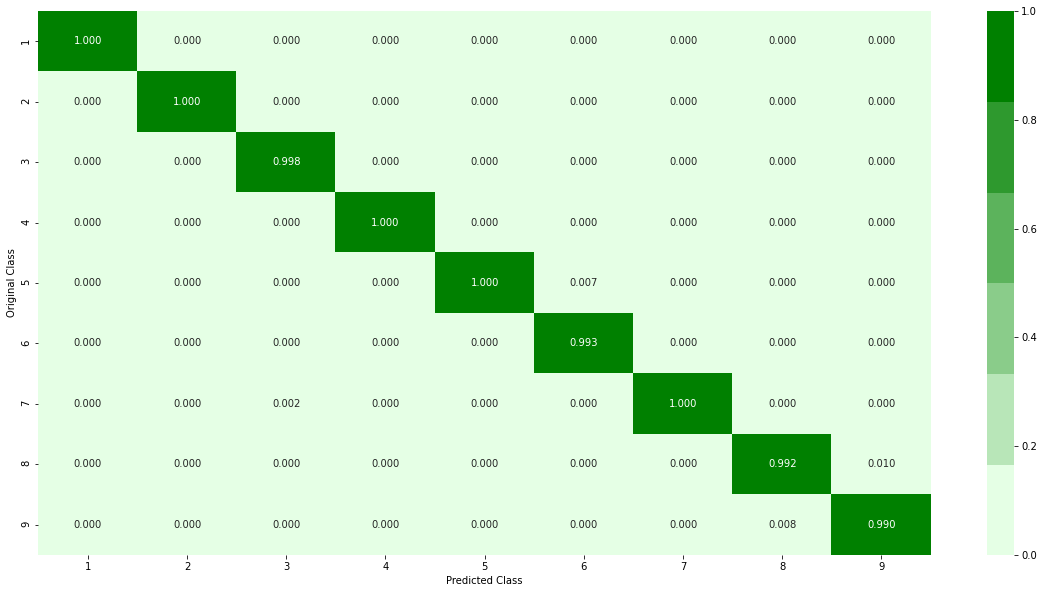

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


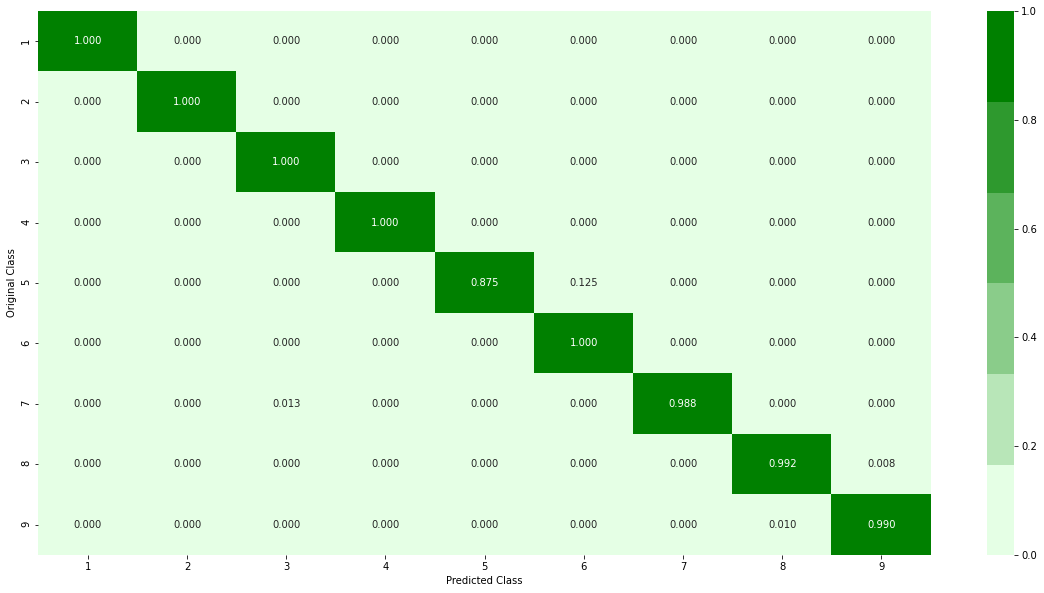

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.close()
plot_confusion_matrix(y_test,sig_clf.predict(X_test))

In [2]:
from scipy import sparse
import pickle
import pandas as pd
from sklearn.preprocessing import normalize

print('\nLoading pixel_array and pickles')
pixel_array = pickle.load(open('/content/gdrive/My Drive/Colab Notebooks/Malware uploads/pixel_array.pkl', 'rb'))
files = pickle.load(open('/content/gdrive/My Drive/Colab Notebooks/files.pkl', 'rb'))
y_for_bytes = pickle.load(open('/content/gdrive/My Drive/Colab Notebooks/Malware uploads/y_values_for_bytes.pkl','rb'))

for i in range(len(files)):
  files[i] = files[i][53:-4]

print('\nLoading byte_matrix')
byte_matrix = sparse.load_npz('/content/gdrive/My Drive/Colab Notebooks/Malware uploads/normalized_byte.npz')
byte_matrix = byte_matrix.todense()
byte_matrix = pd.DataFrame(byte_matrix)
byte_matrix['Id'] = y_for_bytes['Id']

print('\nLoading unigram asm')
asm_matrix_uni = sparse.load_npz('/content/gdrive/My Drive/Colab Notebooks/Malware uploads/opcode_unigram_vect.npz')
asm_matrix_uni = asm_matrix_uni.todense()
asm_matrix_uni = normalize(asm_matrix_uni)
asm_matrix_uni = pd.DataFrame(asm_matrix_uni)
asm_matrix_uni['Id'] = files

print('\nLoading asm_matrix')
asm_matrix = sparse.load_npz('/content/gdrive/My Drive/Colab Notebooks/opcode_bigram_vect.npz')
asm_matrix = asm_matrix.todense()
asm_matrix = normalize(asm_matrix)
asm_matrix = pd.DataFrame(asm_matrix)
asm_matrix['Id'] = files

print('\nMerging matrices')
byte_matrix = pd.merge(byte_matrix, pixel_array, on='Id')
print('\nMatrix merge summary:\n\t0 to 66049 columns belonging to byte_matrix\n\t66049 to {} belonging to pixel_array\n\t{} to {} belonging to asm_matrix'.format(66049+800, 66049+800, 66049+800+676))
byte_matrix = pd.merge(byte_matrix, asm_matrix, on='Id')
byte_matrix = pd.merge(byte_matrix, asm_matrix_uni, on='Id')

print('\nDropping class values')
y = byte_matrix['Class']
byte_matrix = byte_matrix.drop(['Class'], axis=1)
byte_matrix = byte_matrix.drop(['Id'],axis=1)


Loading pixel_array and pickles

Loading byte_matrix

Loading unigram asm

Loading asm_matrix

Merging matrices

Matrix merge summary:
	0 to 66049 columns belonging to byte_matrix
	66049 to 66849 belonging to pixel_array
	66849 to 67525 belonging to asm_matrix

Dropping class values


# Model-6: ASM bigrams + ASM unigrams + Bytes bigram + ASM Pixel

## Random forest

In [11]:
from scipy import sparse
import pickle
import pandas as pd
from sklearn.preprocessing import normalize

print('\nLoading pixel_array and pickles')
pixel_array = pickle.load(open('/content/gdrive/My Drive/Colab Notebooks/Malware uploads/pixel_array.pkl', 'rb'))
files = pickle.load(open('/content/gdrive/My Drive/Colab Notebooks/files.pkl', 'rb'))
y_for_bytes = pickle.load(open('/content/gdrive/My Drive/Colab Notebooks/Malware uploads/y_values_for_bytes.pkl','rb'))

for i in range(len(files)):
  files[i] = files[i][53:-4]

print('\nLoading byte_matrix')
byte_matrix = sparse.load_npz('/content/gdrive/My Drive/Colab Notebooks/Malware uploads/normalized_byte.npz')
byte_matrix = byte_matrix.todense()
byte_matrix = pd.DataFrame(byte_matrix)
byte_matrix['Id'] = y_for_bytes['Id']

print('\nLoading unigram asm')
asm_matrix_uni = sparse.load_npz('/content/gdrive/My Drive/Colab Notebooks/Malware uploads/opcode_unigram_vect.npz')
asm_matrix_uni = asm_matrix_uni.todense()
asm_matrix_uni = normalize(asm_matrix_uni)
asm_matrix_uni = pd.DataFrame(asm_matrix_uni)
asm_matrix_uni['Id'] = files

print('\nLoading asm_matrix')
asm_matrix = sparse.load_npz('/content/gdrive/My Drive/Colab Notebooks/opcode_bigram_vect.npz')
asm_matrix = asm_matrix.todense()
asm_matrix = normalize(asm_matrix)
asm_matrix = pd.DataFrame(asm_matrix)
asm_matrix['Id'] = files

print('\nMerging matrices')
byte_matrix = pd.merge(byte_matrix, pixel_array, on='Id')
print('\nMatrix merge summary:\n\t0 to 66049 columns belonging to byte_matrix\n\t66049 to {} belonging to pixel_array\n\t{} to {} belonging to asm_matrix'.format(66049+800, 66049+800, 66049+800+676))
byte_matrix = pd.merge(byte_matrix, asm_matrix, on='Id')
byte_matrix = pd.merge(byte_matrix, asm_matrix_uni, on='Id')

print('\nDropping class values')
y = byte_matrix['Class']
byte_matrix = byte_matrix.drop(['Class'], axis=1)
byte_matrix = byte_matrix.drop(['Id'],axis=1)


Loading pixel_array and pickles

Loading byte_matrix

Loading unigram asm

Loading asm_matrix

Merging matrices

Matrix merge summary:
	0 to 66049 columns belonging to byte_matrix
	66049 to 66849 belonging to pixel_array
	66849 to 67525 belonging to asm_matrix

Dropping class values


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(byte_matrix, y, test_size=0.2, stratify=y)

For values of best alpha =  500 The train log loss is: 0.01386524033632445
For values of best alpha =  500 The test log loss is: 0.011565943526823889
Number of misclassified points  0.0
-------------------------------------------------- Confusion matrix --------------------------------------------------


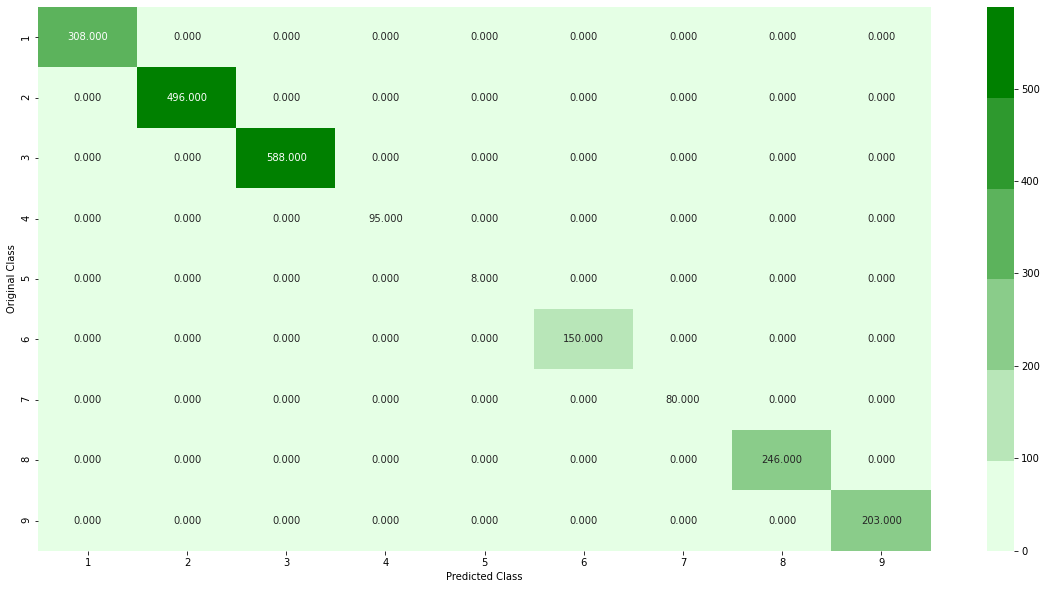

-------------------------------------------------- Precision matrix --------------------------------------------------


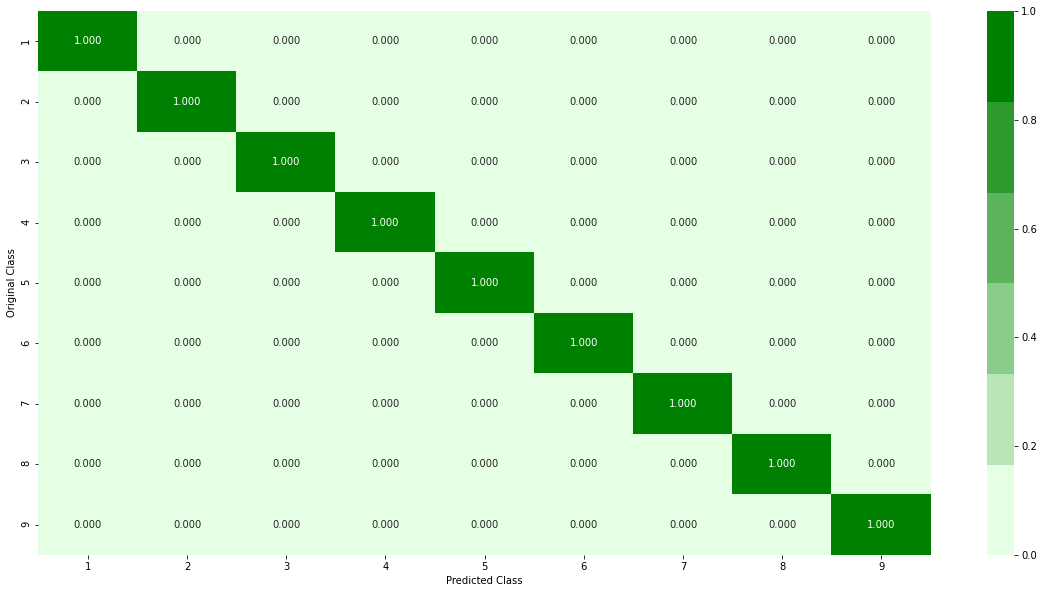

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


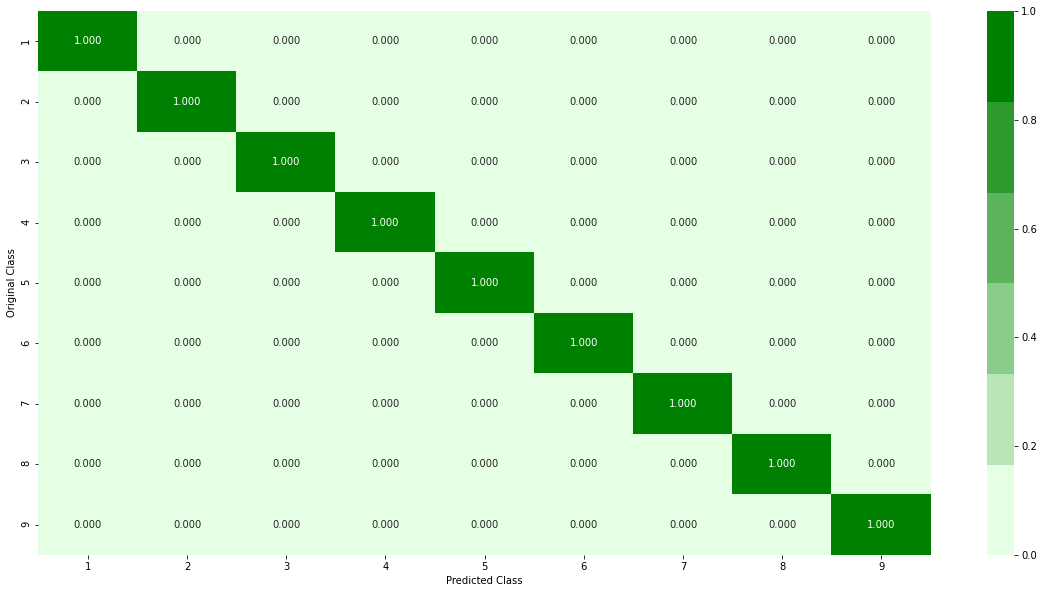

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

best_alpha = 500

r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', 500, "The train log loss is:",log_loss(y_train, predict_y))
#predict_y = sig_clf.predict_proba(X_cv)
#print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', 500, "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

# Summary of last three

Model-4 ASM + Bytes with all features as mentioned

        MODEL/LOSS          TRAIN           TEST           ALPHA        Misclassified points
      Random forest         0.013           0.029           500               0.5575

Model-5: ASM + Bytes + ASM bigrams

        MODEL/LOSS          TRAIN           TEST           ALPHA        Misclassified points
      Random forest         0.011           0.024           500               0.5059
         XGBoost            0.008           0.017           ---               0.2759

Model-6: ASM bigrams + ASM unigrams + Bytes bigram + ASM Pixel

        MODEL/LOSS          TRAIN           TEST           ALPHA        Misclassified points
      Random forest         0.013           0.011           500                 0